# Zalando MNIST GAN 👕👖🧤👚👗👘

En este cuaderno se implementa una red generativa adversaria (GAN) para generar imágenes de moda a partir del conjunto de datos Zalando MNIST. El conjunto de datos Zalando MNIST es un conjunto de datos de imágenes de moda que contiene 60,000 imágenes de 28x28 píxeles en escala de grises. Las imágenes pertenecen a 10 clases diferentes de moda.


In [1]:
# Importacion de librerías necesarias
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

### Carga del dataset


In [ ]:
# Cargamos el dataset
from torchvision import datasets, transforms

# Transformación de los datos
# Declaro un transformador que convierte los datos a tensores y los normaliza
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# Descarga y carga del dataset
trainset = datasets.FashionMNIST(
    '~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)

### Visualización de datos


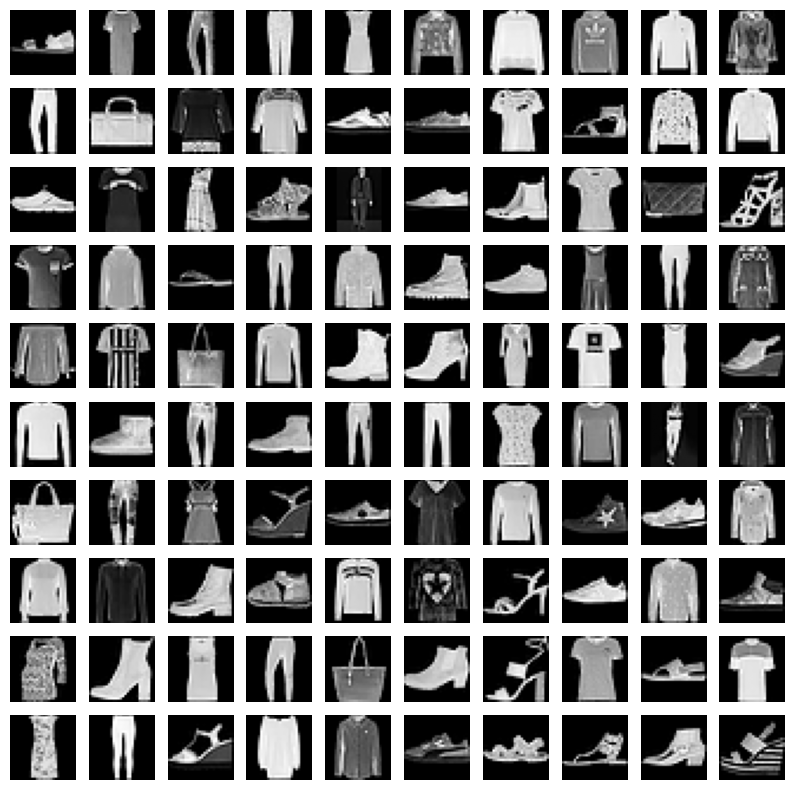

In [3]:
# Muestra las 100 primeras imágenes
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True)
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Función para mostrar imágenes en blanco y negro


def imshow(image, ax=None, normalize=False):
    """Imshow for Tensor."""
    if ax is None:
        _, ax = plt.subplots()
    image = image.numpy().squeeze()

    if normalize:
        mean = np.array([0.5])
        std = np.array([0.5])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image, cmap='gray')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax


# Muestra las imágenes
fig, axes = plt.subplots(figsize=(10, 10), ncols=10, nrows=10)
for i in range(100):
    row = i // 10
    col = i % 10
    ax = axes[row, col]
    imshow(images[i], ax=ax, normalize=False)
plt.show()

### Contrucción de la GAN


In [4]:
# Extraemos el tensor de entrenamiento
X_train_tensor = trainset.data

#### Generador


In [5]:
LATENT_DIM = 100

generator = nn.Sequential(
   # Capa densa inicial
   nn.Linear(LATENT_DIM, 7 * 7 * 256, bias=False),
   nn.BatchNorm1d(7 * 7 * 256),
   nn.LeakyReLU(0.2, inplace=True),

   # Redimensión a las dimensiones iniciales
   nn.Unflatten(1, (256, 7, 7)),

   # Primera capa de convolución transpuesta (7x7 -> 14x14)
   nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
   nn.BatchNorm2d(128),
   nn.LeakyReLU(0.2, inplace=True),

   # Segunda capa de convolución transpuesta (14x14 -> 28x28)
   nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
   nn.BatchNorm2d(64),
   nn.LeakyReLU(0.2, inplace=True),
   
   # Tercera capa de convolución transpuesta (28x28 -> 28x28)
   nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1, bias=False),
   nn.BatchNorm2d(32),
   nn.LeakyReLU(0.2, inplace=True),

   # Capa final de ajuste (28x28)
   nn.Conv2d(32, 1, kernel_size=3, padding=1, bias=False),
   nn.Tanh()
)

# Resumen de la arquitectura del generador
print(generator)

Sequential(
  (0): Linear(in_features=100, out_features=12544, bias=False)
  (1): BatchNorm1d(12544, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2, inplace=True)
  (3): Unflatten(dim=1, unflattened_size=(256, 7, 7))
  (4): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): LeakyReLU(negative_slope=0.2, inplace=True)
  (7): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): LeakyReLU(negative_slope=0.2, inplace=True)
  (10): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (11): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): LeakyReLU(negative_slope=0.2, inplace=True)
  (13): Conv2d(32, 1, kerne

In [6]:
# Dimensiones de cada capa
noise = torch.randn(1, LATENT_DIM)
x = noise
generator.eval()  # Set the generator to evaluation mode
for layer in generator:
    x = layer(x)
    print(f"{x.shape}\t{layer.__class__.__name__}")

torch.Size([1, 12544])	Linear
torch.Size([1, 12544])	BatchNorm1d
torch.Size([1, 12544])	LeakyReLU
torch.Size([1, 256, 7, 7])	Unflatten
torch.Size([1, 128, 14, 14])	ConvTranspose2d
torch.Size([1, 128, 14, 14])	BatchNorm2d
torch.Size([1, 128, 14, 14])	LeakyReLU
torch.Size([1, 64, 28, 28])	ConvTranspose2d
torch.Size([1, 64, 28, 28])	BatchNorm2d
torch.Size([1, 64, 28, 28])	LeakyReLU
torch.Size([1, 32, 28, 28])	ConvTranspose2d
torch.Size([1, 32, 28, 28])	BatchNorm2d
torch.Size([1, 32, 28, 28])	LeakyReLU
torch.Size([1, 1, 28, 28])	Conv2d
torch.Size([1, 1, 28, 28])	Tanh


Las dimensiones de la imagen generada son: torch.Size([1, 1, 28, 28])
El rango de valores de la imagen generada es: [-0.05488154664635658, 0.018753323704004288]


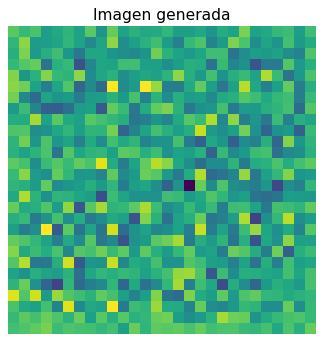

In [7]:
# Comprobamos que el generador funciona correctamente

# Generamos una imagen aleatoria normalizada
noise = torch.randn(1, LATENT_DIM)

# Generamos una imagen a partir del ruido
generated_image = generator(noise)

# Mostramos las dimensiones de la imagen generada
print(f'Las dimensiones de la imagen generada son: {generated_image.shape}')

# Verifica el rango de valores de la imagen generada
print(
    f'El rango de valores de la imagen generada es: [{generated_image.min()}, {generated_image.max()}]')

# Muestra la imagen de generada
# Increased DPI from 40 to 80 for larger image
plt.figure(dpi=80, figsize=(5, 5))
plt.imshow((generated_image.detach().numpy()[0, 0] + 1) / 2)
plt.axis('off')
plt.title('Imagen generada', fontsize=14)  # Increased font size of title
plt.show()

#### Discriminador


In [8]:
discriminator = nn.Sequential(
    # Primera capa de convolución
    nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Dropout(0.3),

    # Segunda capa de convolución
    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Dropout(0.3),

    # Capa de aplanado
    nn.Flatten(),

    # Capa final
    nn.Linear(128 * 7 * 7, 1),
    nn.Sigmoid()
)

# Resumen de la arquitectura del discriminador
print(discriminator)

Sequential(
  (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (1): LeakyReLU(negative_slope=0.2, inplace=True)
  (2): Dropout(p=0.3, inplace=False)
  (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (4): LeakyReLU(negative_slope=0.2, inplace=True)
  (5): Dropout(p=0.3, inplace=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=6272, out_features=1, bias=True)
  (8): Sigmoid()
)


In [9]:
# Probamos el discriminador con una imagen generada
discriminator.eval()  # Set the discriminator to evaluation mode
decision = discriminator(generated_image)

print(f'La decisión del discriminador es: {decision.item()}')

La decisión del discriminador es: 0.49898889660835266


> Como el discriminador no está entrenado, no conoce su objetivo, es por esto que da un resultado cercano a 0.5 dado que no es capaz de saber si la imagen es verdadera o falsa. Por este mismo motivo el generador genera una imagen gris, por que no sabe que tiene que generar.


In [10]:
# Inspecciona un lote del dataset
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=100, shuffle=True)
dataiter = iter(trainloader)
images, labels = next(dataiter)

print(f'Dimensiones del lote de imágenes: {images.shape}')
print(f'Rango: de {images.min().item()} a {images.max().item()}')

Dimensiones del lote de imágenes: torch.Size([100, 1, 28, 28])
Rango: de -1.0 a 1.0


In [11]:
# Parámetros del entrenamiento
EPOCHS = 200
LATENT_DIM = 100
BATCH_SIZE = 128
LEARNING_RATE = 0.0002

In [12]:
# Indicamos los optimizadores y las funciones de pérdida
criterion = nn.BCELoss()
gen_optimizer = torch.optim.Adam(generator.parameters(), lr=LEARNING_RATE)
disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=LEARNING_RATE)

**Gradientes**: Son vectores que indican la dirección y magnitud en la que deben ajustarse los pesos de un modelo para minimizar la función de perdida.


In [13]:
# Inicializar los pesos
def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.Linear)):
        nn.init.normal_(m.weight, 0.0, 0.02)
        
generator.apply(weights_init)
discriminator.apply(weights_init)


Sequential(
  (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (1): LeakyReLU(negative_slope=0.2, inplace=True)
  (2): Dropout(p=0.3, inplace=False)
  (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (4): LeakyReLU(negative_slope=0.2, inplace=True)
  (5): Dropout(p=0.3, inplace=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=6272, out_features=1, bias=True)
  (8): Sigmoid()
)

In [14]:
# Configurar el dispositivo para el entrenamiento
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Usando dispositivo: {device}')

# Mover los modelos al dispositivo
generator = generator.to(device)
discriminator = discriminator.to(device)


Usando dispositivo: cuda


In [15]:
import torchvision.utils as vutils # Librería para visualización de imágenes

def save_images(fake_images, epoch_label):
    """
    Guarda una cuadrícula de imágenes generadas
    
    Args:
        fake_images (torch.Tensor): Tensor de imágenes generadas
        epoch_label (str): Etiqueta para el nombre del archivo
    """
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.title(f"Imágenes Generadas - {epoch_label}")
    
    # Hacer un grid con las imágenes
    grid = vutils.make_grid(
        fake_images.cpu().detach(),
        padding=2,
        normalize=True,
        nrow=4
    )
    
    # Convertir de tensor a numpy para mostrar
    plt.imshow(grid.permute(1, 2, 0).numpy(), cmap='gray')
    plt.savefig(f'images/generated_images_{epoch_label}.png')
    plt.close()

Epoch [1/200] D_loss: 0.6909, G_loss: 0.9714


Epoch [2/200] D_loss: 0.6004, G_loss: 1.1407


Epoch [3/200] D_loss: 0.6380, G_loss: 1.0378


Epoch [4/200] D_loss: 0.5731, G_loss: 1.1607


Epoch [5/200] D_loss: 0.5516, G_loss: 1.3703


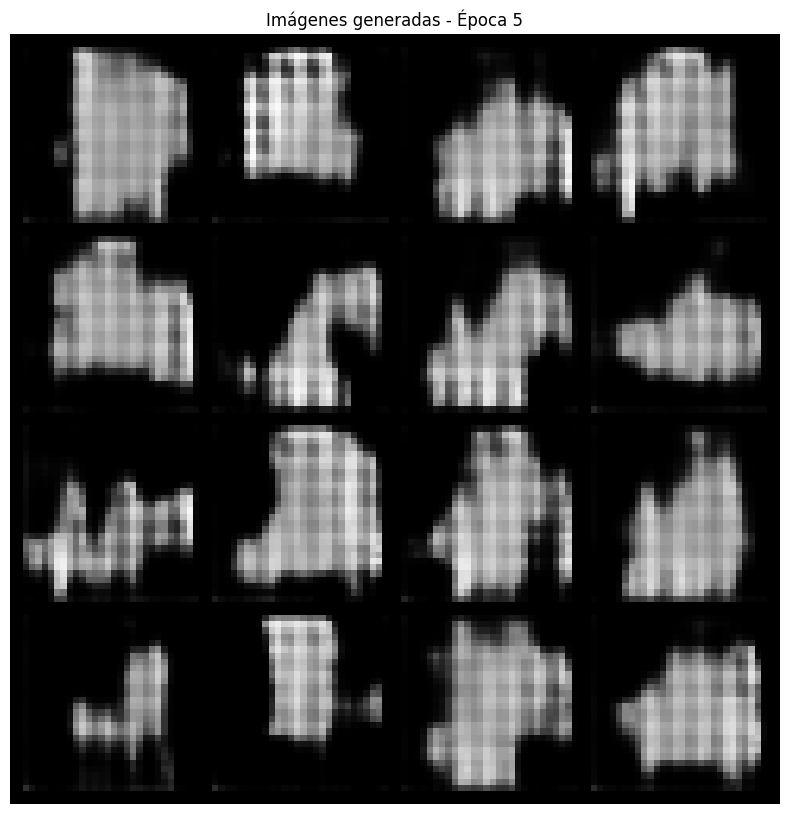

Epoch [6/200] D_loss: 0.5177, G_loss: 1.4215


Epoch [7/200] D_loss: 0.4686, G_loss: 1.7404


Epoch [8/200] D_loss: 0.4841, G_loss: 1.5308


Epoch [9/200] D_loss: 0.4785, G_loss: 1.6220


Epoch [10/200] D_loss: 0.4501, G_loss: 1.6977


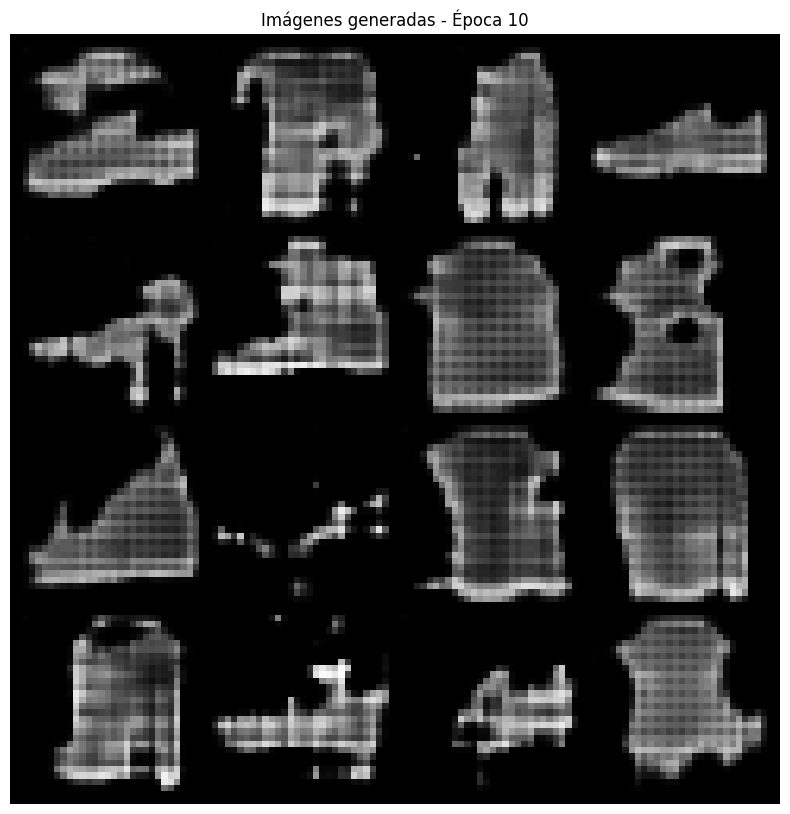

Epoch [11/200] D_loss: 0.4601, G_loss: 1.6663


Epoch [12/200] D_loss: 0.5858, G_loss: 1.4511


Epoch [13/200] D_loss: 0.5368, G_loss: 1.3785


Epoch [14/200] D_loss: 0.5712, G_loss: 1.2528


Epoch [15/200] D_loss: 0.5698, G_loss: 1.2242


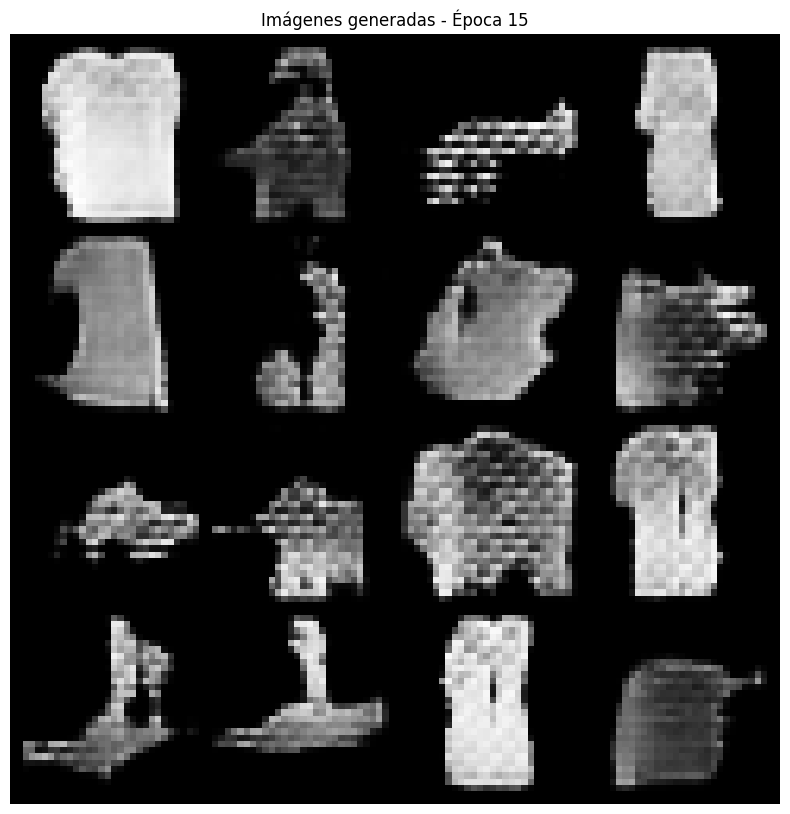

Epoch [16/200] D_loss: 0.5865, G_loss: 1.1548


Epoch [17/200] D_loss: 0.5742, G_loss: 1.1782


Epoch [18/200] D_loss: 0.5946, G_loss: 1.1767


Epoch [19/200] D_loss: 0.5953, G_loss: 1.1537


Epoch [20/200] D_loss: 0.5985, G_loss: 1.0972


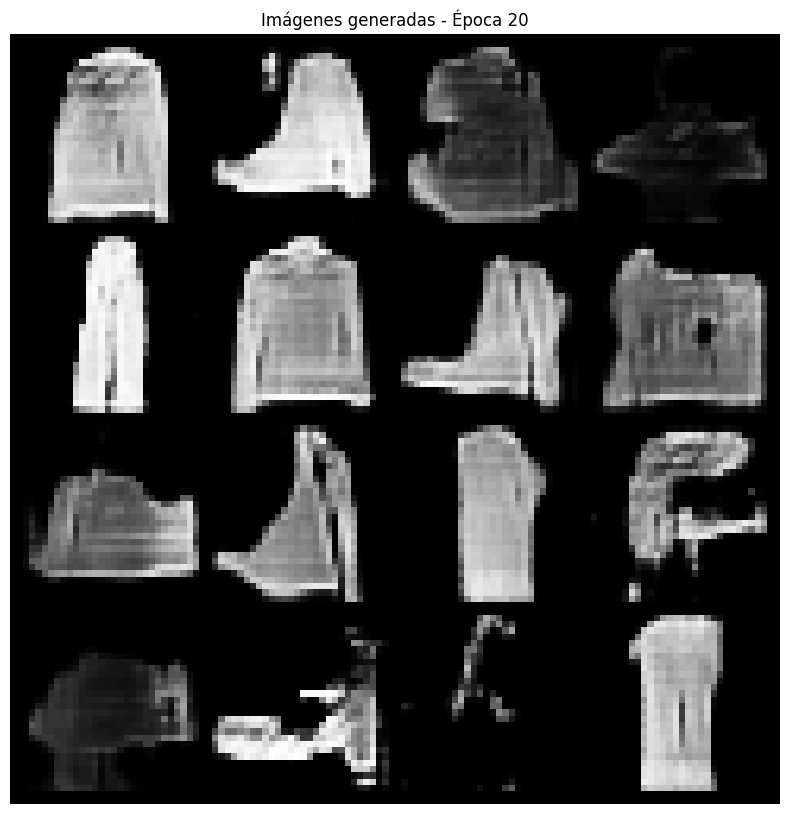

Epoch [21/200] D_loss: 0.6133, G_loss: 1.0818


Epoch [22/200] D_loss: 0.6180, G_loss: 1.0431


Epoch [23/200] D_loss: 0.6126, G_loss: 1.0616


Epoch [24/200] D_loss: 0.6194, G_loss: 1.0644


Epoch [25/200] D_loss: 0.6185, G_loss: 1.0563


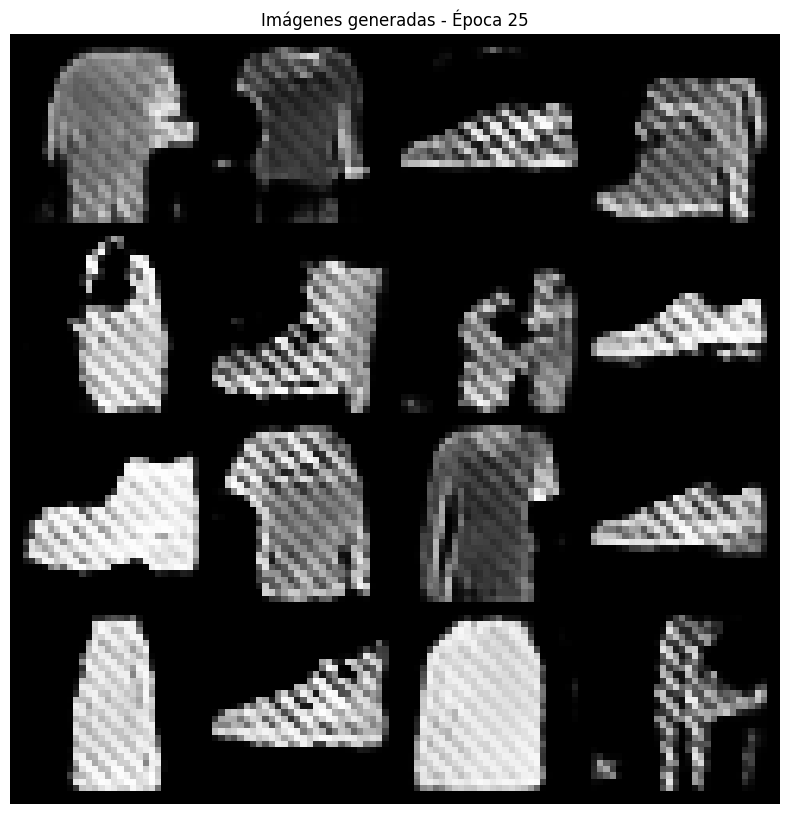

Epoch [26/200] D_loss: 0.6186, G_loss: 1.0254


Epoch [27/200] D_loss: 0.6201, G_loss: 1.0485


Epoch [28/200] D_loss: 0.6207, G_loss: 1.0194


Epoch [29/200] D_loss: 0.6245, G_loss: 1.0153


Epoch [30/200] D_loss: 0.6250, G_loss: 1.0182


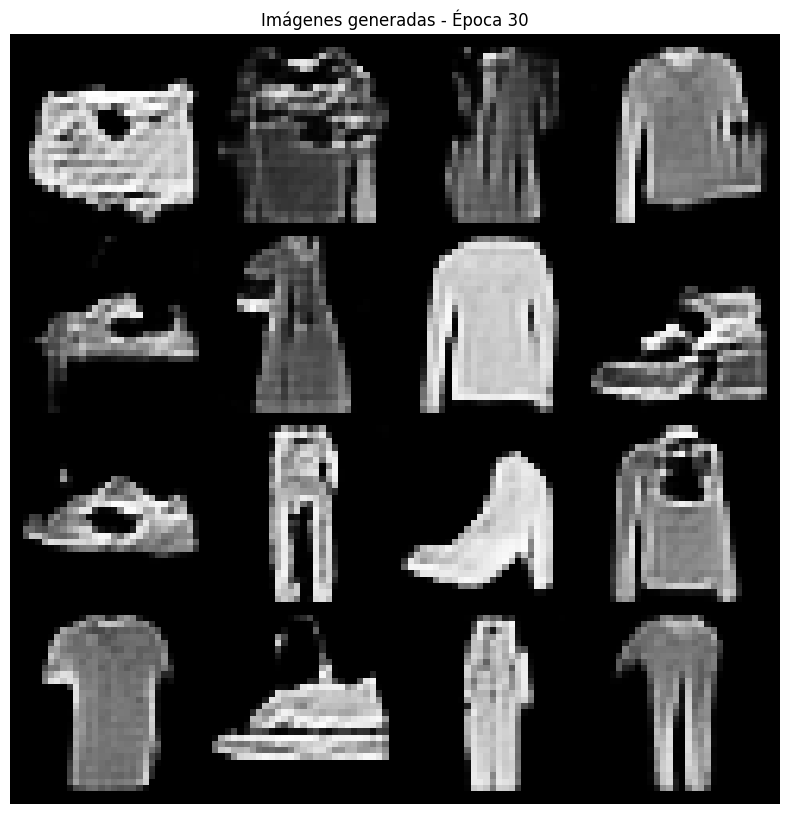

Epoch [31/200] D_loss: 0.6268, G_loss: 1.0137


Epoch [32/200] D_loss: 0.6255, G_loss: 1.0095


Epoch [33/200] D_loss: 0.6303, G_loss: 0.9999


Epoch [34/200] D_loss: 0.6280, G_loss: 1.0208


Epoch [35/200] D_loss: 0.6305, G_loss: 0.9981


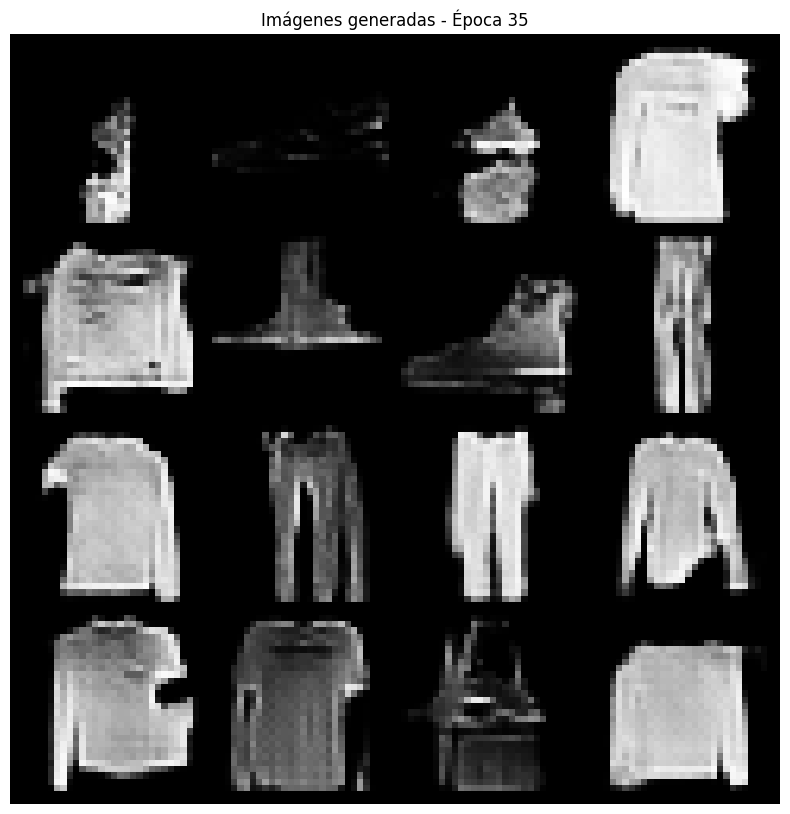

Epoch [36/200] D_loss: 0.6290, G_loss: 1.0101


Epoch [37/200] D_loss: 0.6305, G_loss: 1.0023


Epoch [38/200] D_loss: 0.6292, G_loss: 0.9978


Epoch [39/200] D_loss: 0.6331, G_loss: 0.9938


Epoch [40/200] D_loss: 0.6325, G_loss: 0.9914


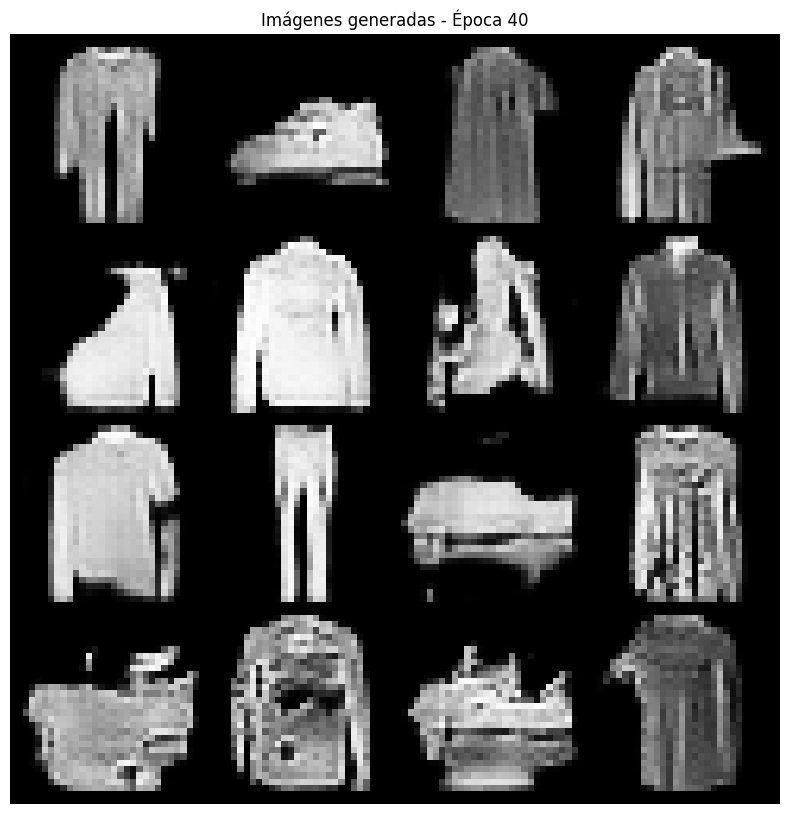

Epoch [41/200] D_loss: 0.6350, G_loss: 0.9948


Epoch [42/200] D_loss: 0.6337, G_loss: 0.9787


Epoch [43/200] D_loss: 0.6370, G_loss: 0.9748


Epoch [44/200] D_loss: 0.6348, G_loss: 0.9853


Epoch [45/200] D_loss: 0.6368, G_loss: 0.9795


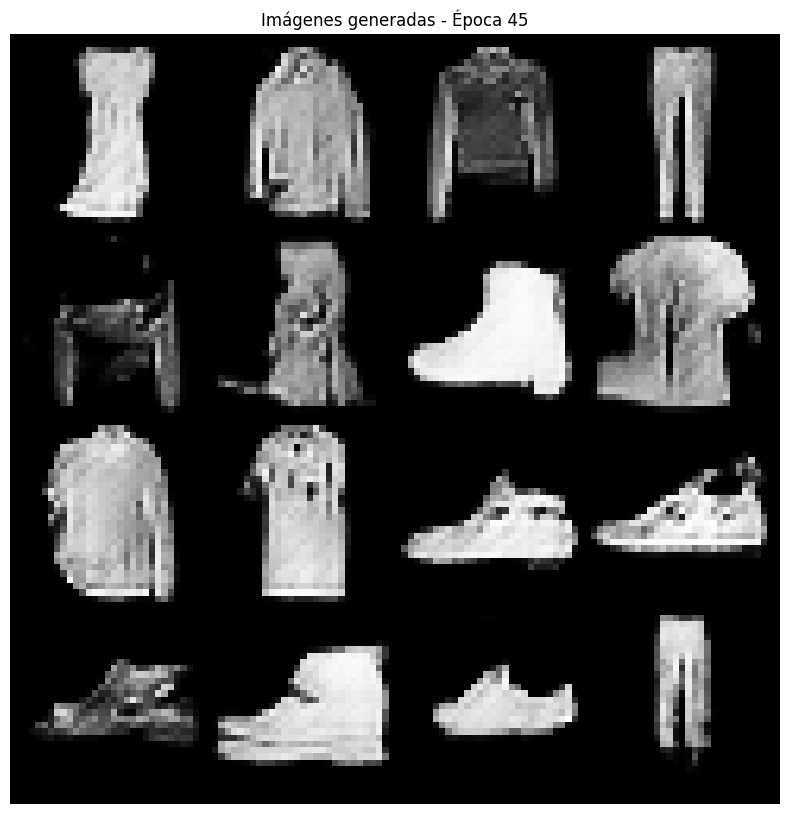

Epoch [46/200] D_loss: 0.6385, G_loss: 0.9760


Epoch [47/200] D_loss: 0.6414, G_loss: 0.9693


Epoch [48/200] D_loss: 0.6426, G_loss: 0.9674


Epoch [49/200] D_loss: 0.6410, G_loss: 0.9657


Epoch [50/200] D_loss: 0.6432, G_loss: 0.9519


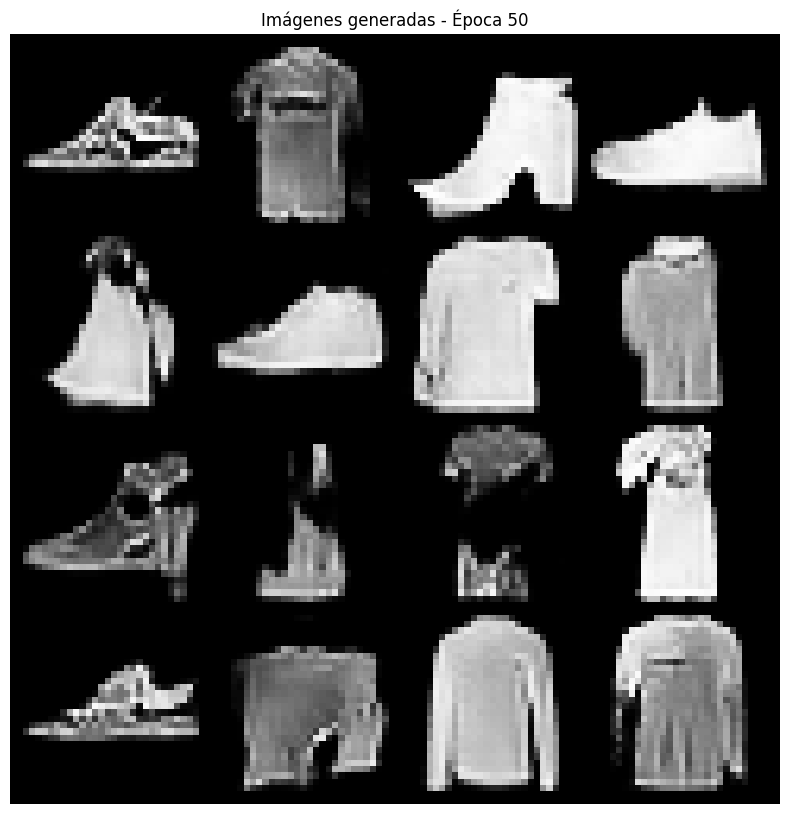

Epoch [51/200] D_loss: 0.6454, G_loss: 0.9502


Epoch [52/200] D_loss: 0.6484, G_loss: 0.9532


Epoch [53/200] D_loss: 0.6487, G_loss: 0.9612


Epoch [54/200] D_loss: 0.6458, G_loss: 0.9410


Epoch [55/200] D_loss: 0.6511, G_loss: 0.9508


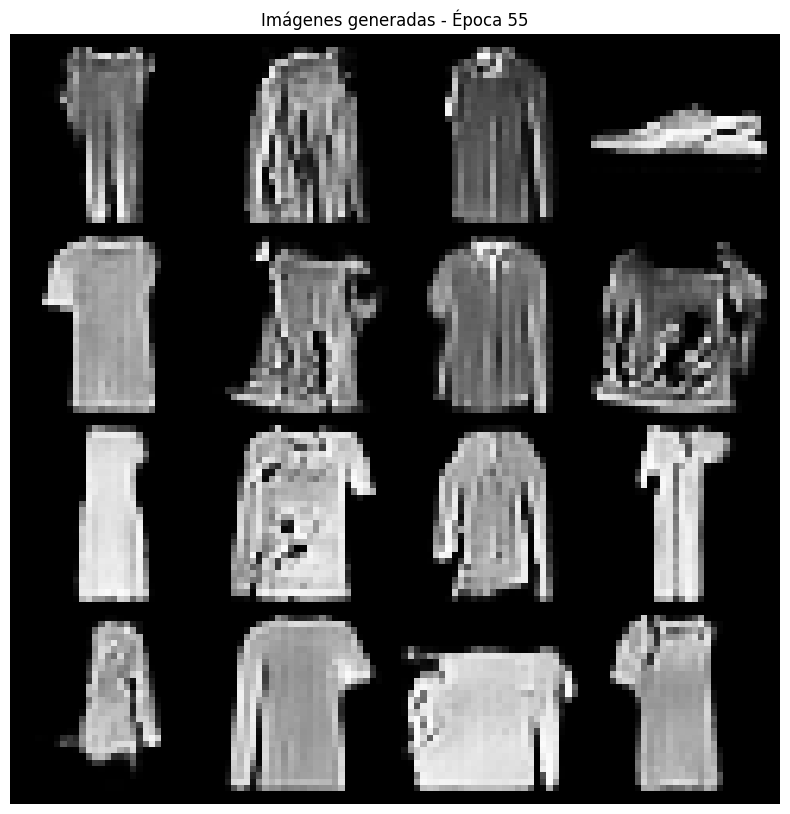

Epoch [56/200] D_loss: 0.6477, G_loss: 0.9320


Epoch [57/200] D_loss: 0.6506, G_loss: 0.9317


Epoch [58/200] D_loss: 0.6508, G_loss: 0.9362


Epoch [59/200] D_loss: 0.6547, G_loss: 0.9200


Epoch [60/200] D_loss: 0.6522, G_loss: 0.9275


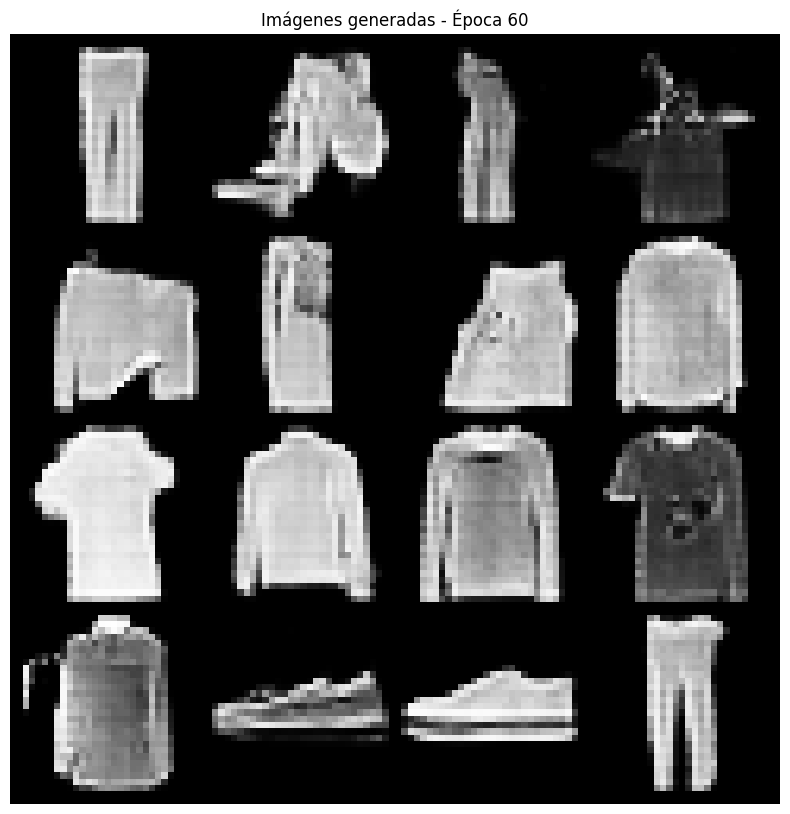

Epoch [61/200] D_loss: 0.6535, G_loss: 0.9249


Epoch [62/200] D_loss: 0.6549, G_loss: 0.9163


Epoch [63/200] D_loss: 0.6540, G_loss: 0.9233


Epoch [64/200] D_loss: 0.6543, G_loss: 0.9184


Epoch [65/200] D_loss: 0.6568, G_loss: 0.9093


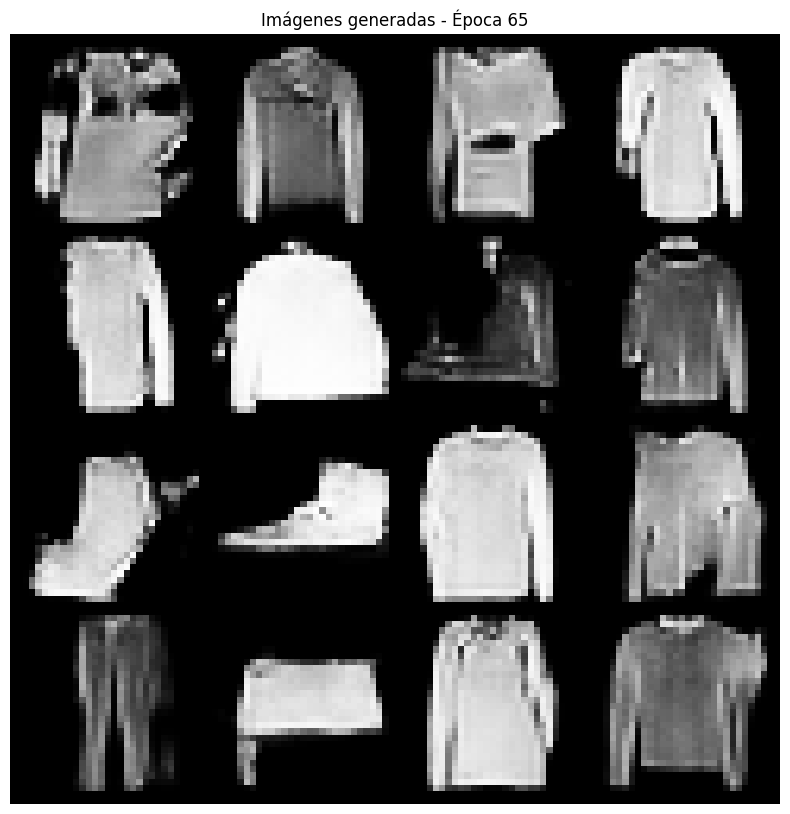

Epoch [66/200] D_loss: 0.6577, G_loss: 0.9034


Epoch [67/200] D_loss: 0.6555, G_loss: 0.9184


Epoch [68/200] D_loss: 0.6547, G_loss: 0.9279


Epoch [69/200] D_loss: 0.6582, G_loss: 0.9121


Epoch [70/200] D_loss: 0.6566, G_loss: 0.9017


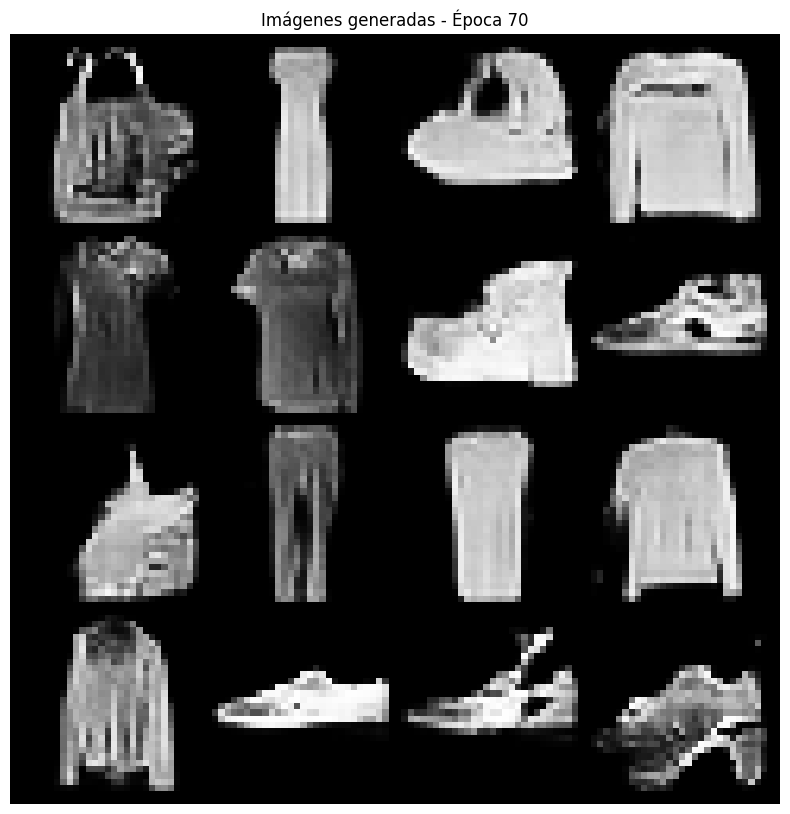

Epoch [71/200] D_loss: 0.6579, G_loss: 0.9042


Epoch [72/200] D_loss: 0.6573, G_loss: 0.9089


Epoch [73/200] D_loss: 0.6586, G_loss: 0.9004


Epoch [74/200] D_loss: 0.6618, G_loss: 0.8960


Epoch [75/200] D_loss: 0.6602, G_loss: 0.9029


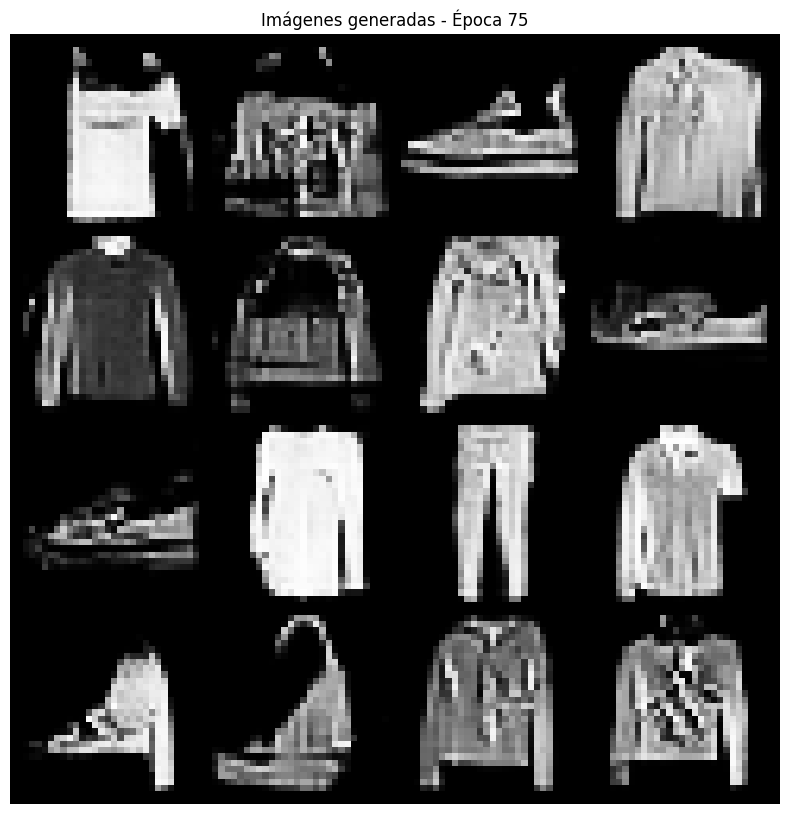

Epoch [76/200] D_loss: 0.6603, G_loss: 0.8951


Epoch [77/200] D_loss: 0.6614, G_loss: 0.8928


Epoch [78/200] D_loss: 0.6602, G_loss: 0.8976


Epoch [79/200] D_loss: 0.6624, G_loss: 0.8871


Epoch [80/200] D_loss: 0.6617, G_loss: 0.8954


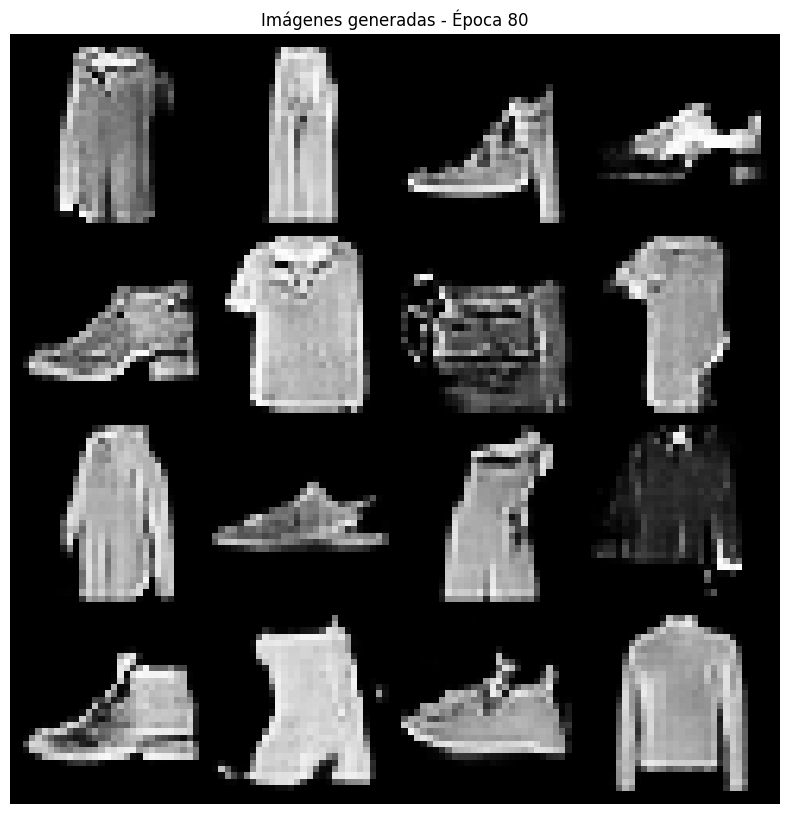

Epoch [81/200] D_loss: 0.6626, G_loss: 0.8875


Epoch [82/200] D_loss: 0.6622, G_loss: 0.8910


Epoch [83/200] D_loss: 0.6635, G_loss: 0.8824


Epoch [84/200] D_loss: 0.6634, G_loss: 0.8868


Epoch [85/200] D_loss: 0.6626, G_loss: 0.8870


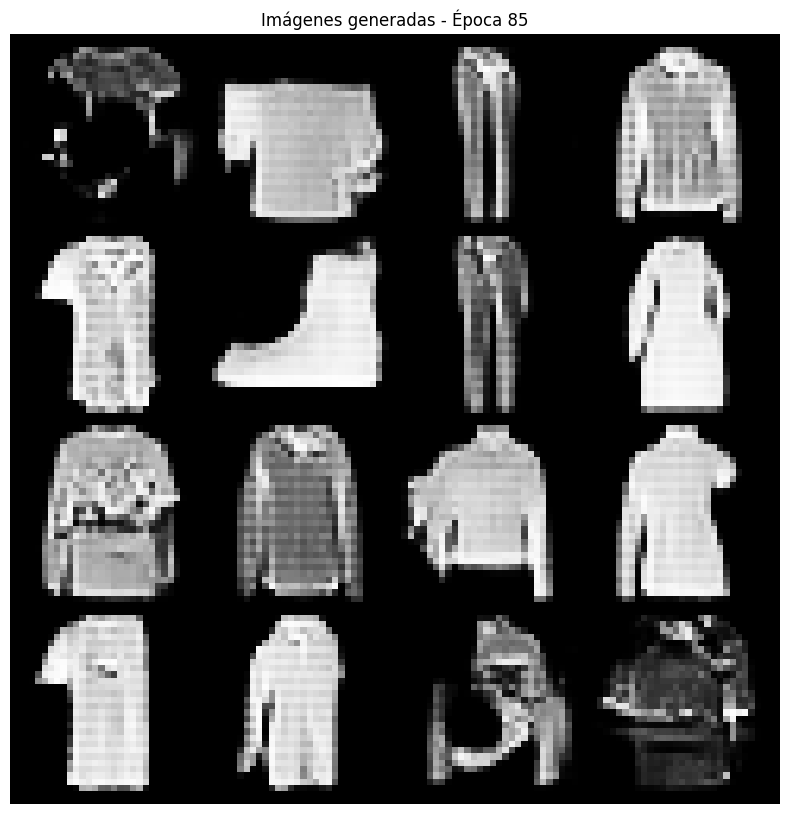

Epoch [86/200] D_loss: 0.6633, G_loss: 0.8949


Epoch [87/200] D_loss: 0.6636, G_loss: 0.8797


Epoch [88/200] D_loss: 0.6649, G_loss: 0.8759


Epoch [89/200] D_loss: 0.6642, G_loss: 0.8818


Epoch [90/200] D_loss: 0.6645, G_loss: 0.8804


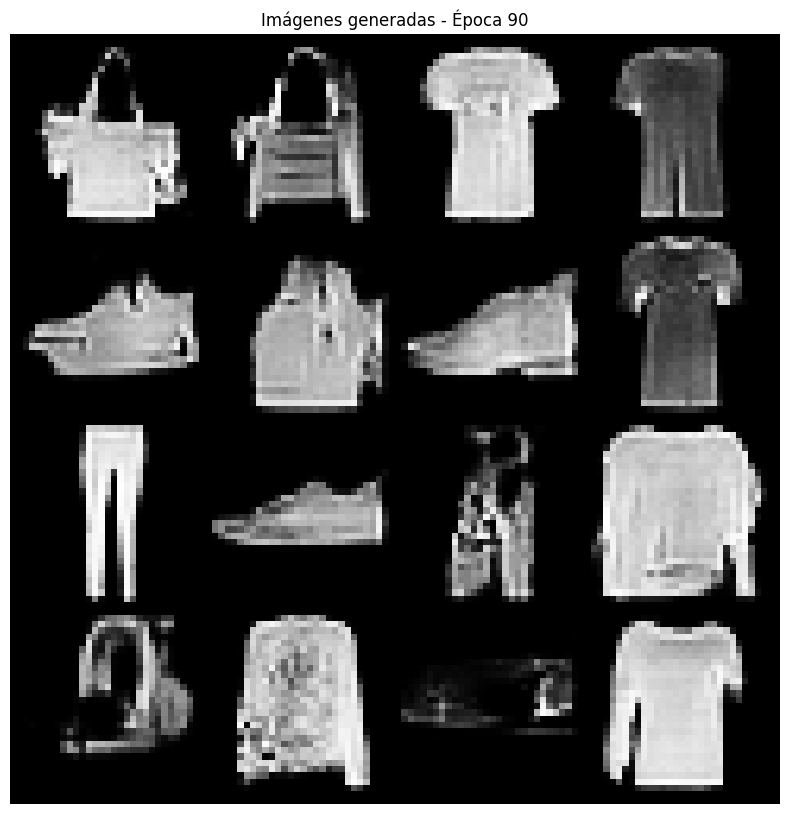

Epoch [91/200] D_loss: 0.6647, G_loss: 0.8787


Epoch [92/200] D_loss: 0.6649, G_loss: 0.8735


Epoch [93/200] D_loss: 0.6660, G_loss: 0.8781


Epoch [94/200] D_loss: 0.6655, G_loss: 0.8767


Epoch [95/200] D_loss: 0.6658, G_loss: 0.8780


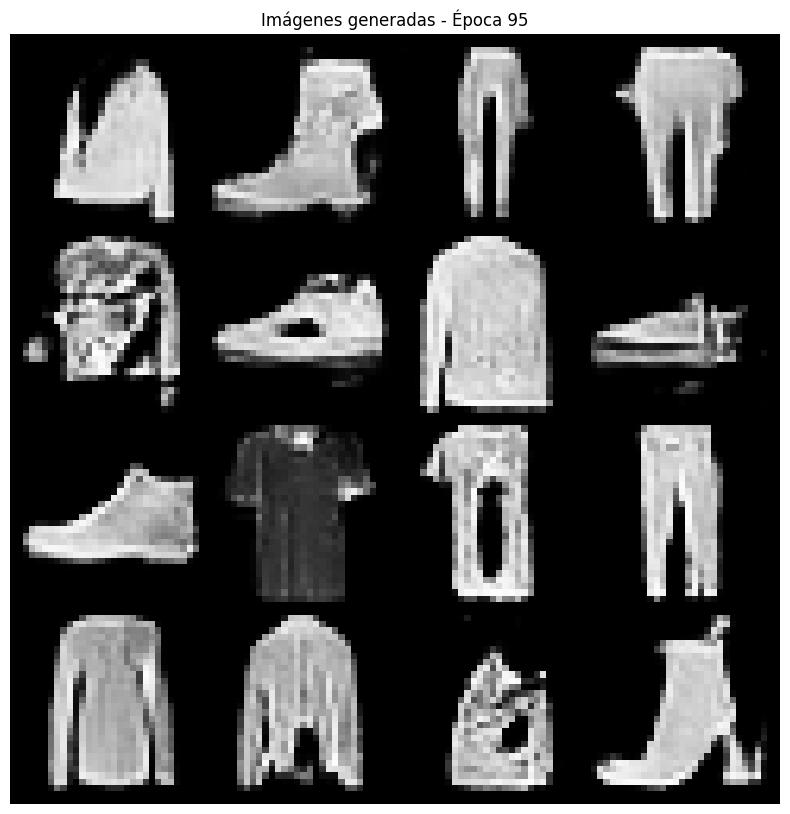

Epoch [96/200] D_loss: 0.6664, G_loss: 0.8756


Epoch [97/200] D_loss: 0.6655, G_loss: 0.8798


Epoch [98/200] D_loss: 0.6641, G_loss: 0.8740


Epoch [99/200] D_loss: 0.6662, G_loss: 0.8721


Epoch [100/200] D_loss: 0.6657, G_loss: 0.8730


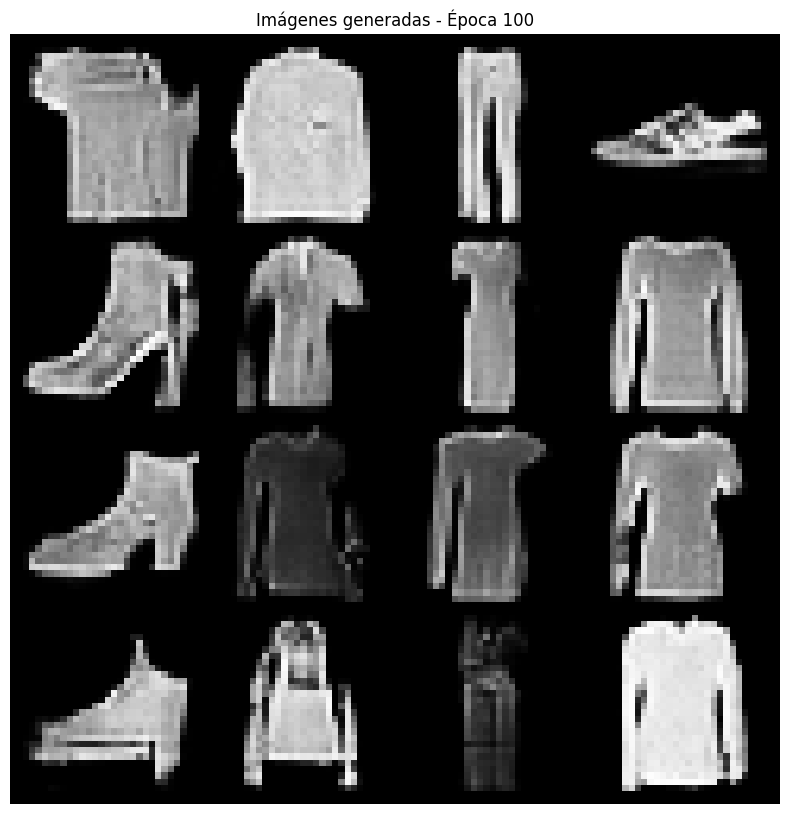

Epoch [101/200] D_loss: 0.6659, G_loss: 0.8844


Epoch [102/200] D_loss: 0.6658, G_loss: 0.8793


Epoch [103/200] D_loss: 0.6663, G_loss: 0.8675


Epoch [104/200] D_loss: 0.6673, G_loss: 0.8650


Epoch [105/200] D_loss: 0.6658, G_loss: 0.8725


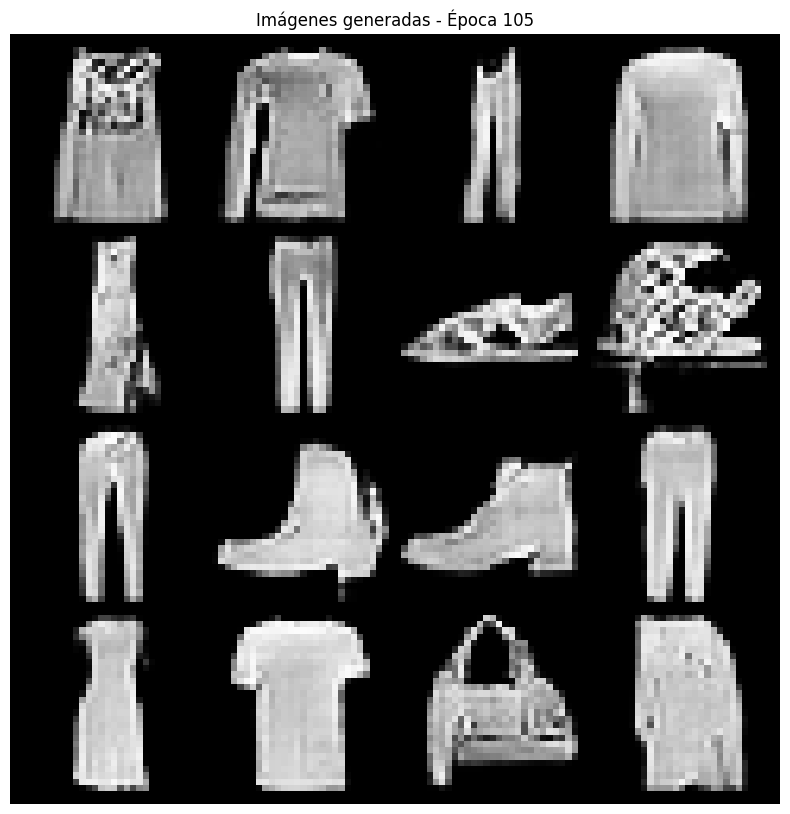

Epoch [106/200] D_loss: 0.6669, G_loss: 0.8705


Epoch [107/200] D_loss: 0.6685, G_loss: 0.8744


Epoch [108/200] D_loss: 0.6669, G_loss: 0.8699


Epoch [109/200] D_loss: 0.6669, G_loss: 0.8662


Epoch [110/200] D_loss: 0.6676, G_loss: 0.8650


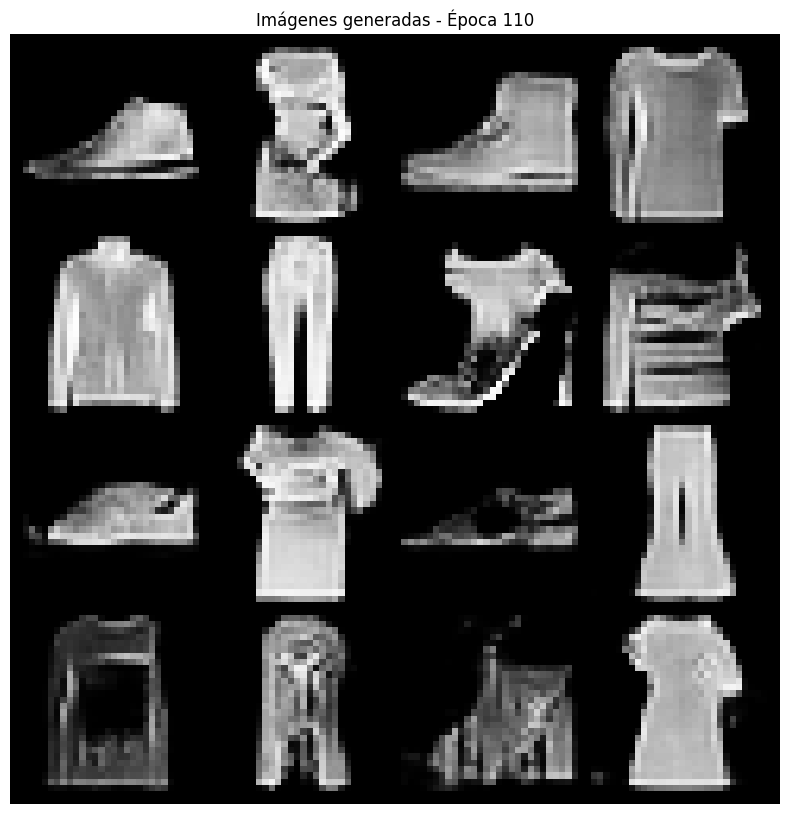

Epoch [111/200] D_loss: 0.6684, G_loss: 0.8674


Epoch [112/200] D_loss: 0.6665, G_loss: 0.8662


Epoch [113/200] D_loss: 0.6649, G_loss: 0.8754


Epoch [114/200] D_loss: 0.6680, G_loss: 0.8723


Epoch [115/200] D_loss: 0.6673, G_loss: 0.8586


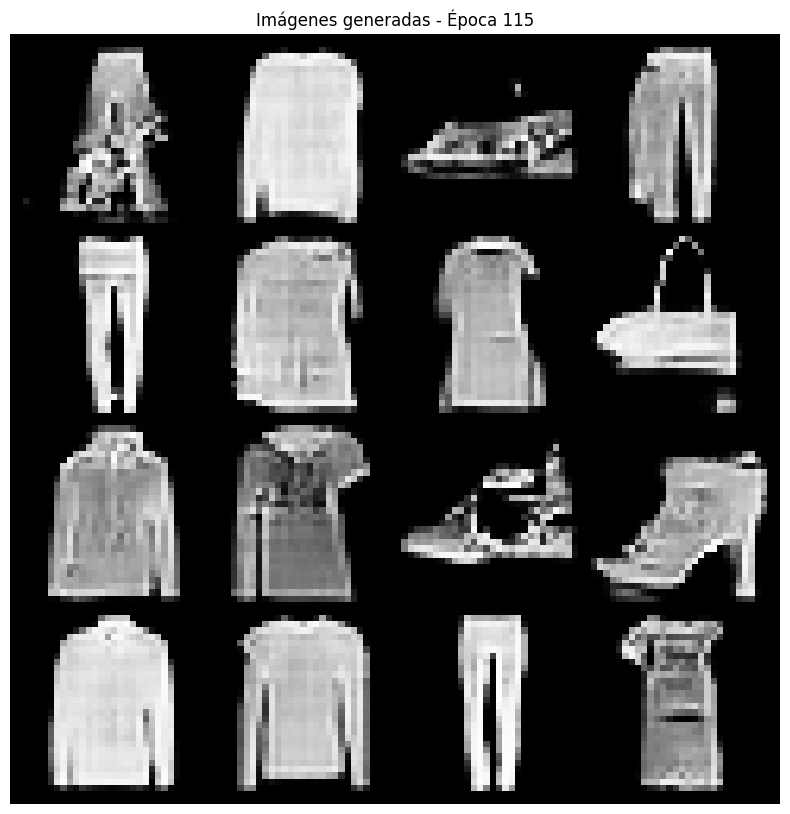

Epoch [116/200] D_loss: 0.6688, G_loss: 0.8634


Epoch [117/200] D_loss: 0.6673, G_loss: 0.8703


Epoch [118/200] D_loss: 0.6696, G_loss: 0.8645


Epoch [119/200] D_loss: 0.6686, G_loss: 0.8590


Epoch [120/200] D_loss: 0.6696, G_loss: 0.8597


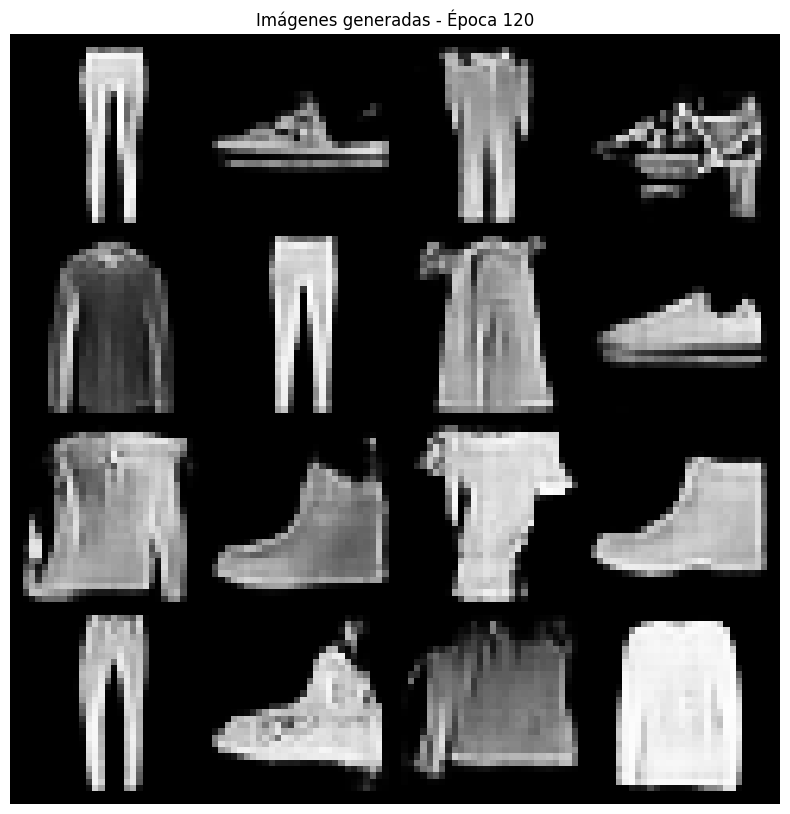

Epoch [121/200] D_loss: 0.6682, G_loss: 0.8603


Epoch [122/200] D_loss: 0.6701, G_loss: 0.8533


Epoch [123/200] D_loss: 0.6696, G_loss: 0.8615


Epoch [124/200] D_loss: 0.6678, G_loss: 0.8662


Epoch [125/200] D_loss: 0.6694, G_loss: 0.8568


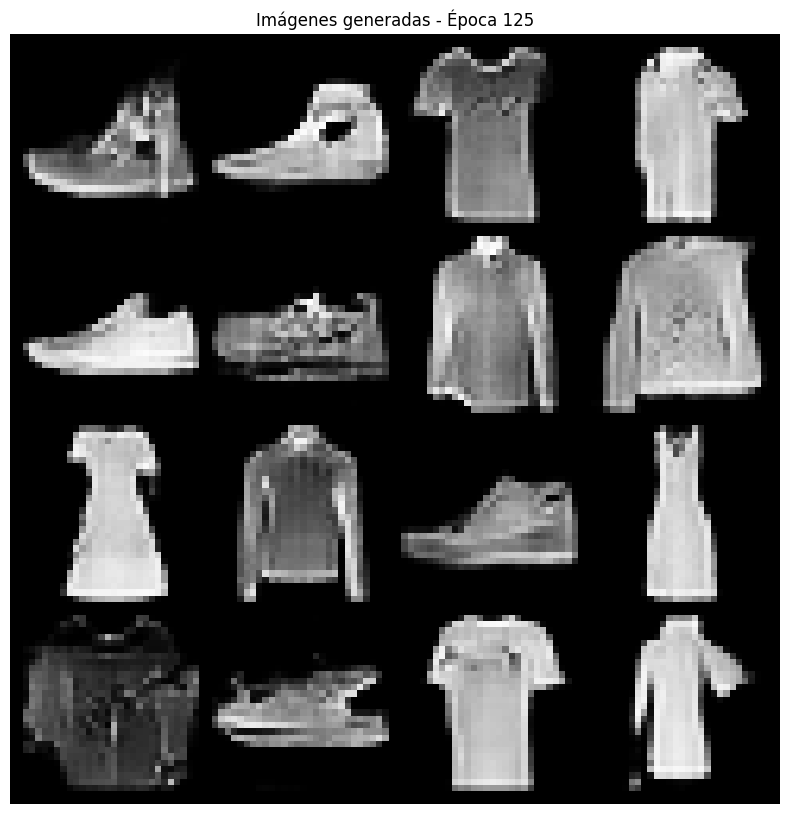

Epoch [126/200] D_loss: 0.6699, G_loss: 0.8555


Epoch [127/200] D_loss: 0.6695, G_loss: 0.8643


Epoch [128/200] D_loss: 0.6684, G_loss: 0.8706


Epoch [129/200] D_loss: 0.6697, G_loss: 0.8629


Epoch [130/200] D_loss: 0.6694, G_loss: 0.8651


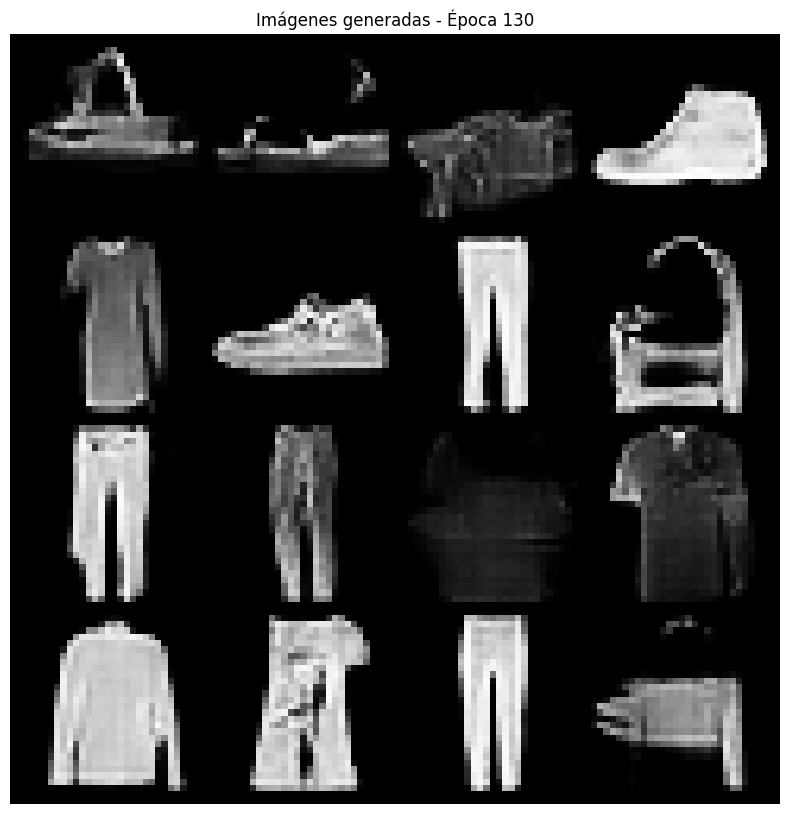

Epoch [131/200] D_loss: 0.6711, G_loss: 0.8551


Epoch [132/200] D_loss: 0.6690, G_loss: 0.8564


Epoch [133/200] D_loss: 0.6693, G_loss: 0.8626


Epoch [134/200] D_loss: 0.6711, G_loss: 0.8536


Epoch [135/200] D_loss: 0.6701, G_loss: 0.8638


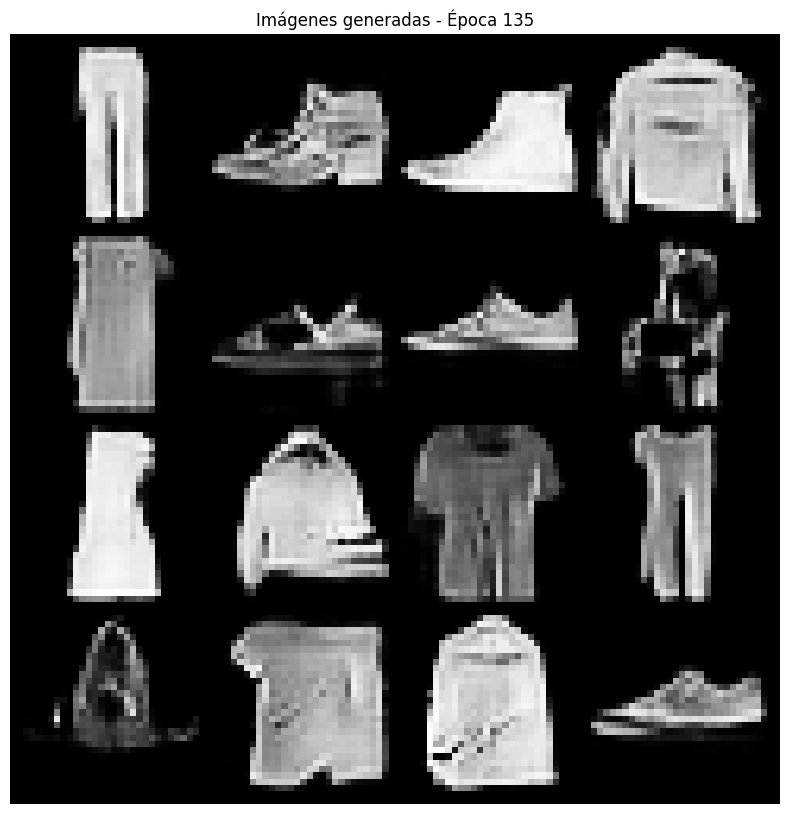

Epoch [136/200] D_loss: 0.6697, G_loss: 0.8568


Epoch [137/200] D_loss: 0.6714, G_loss: 0.8513


Epoch [138/200] D_loss: 0.6709, G_loss: 0.8521


Epoch [139/200] D_loss: 0.6716, G_loss: 0.8658


Epoch [140/200] D_loss: 0.6702, G_loss: 0.8532


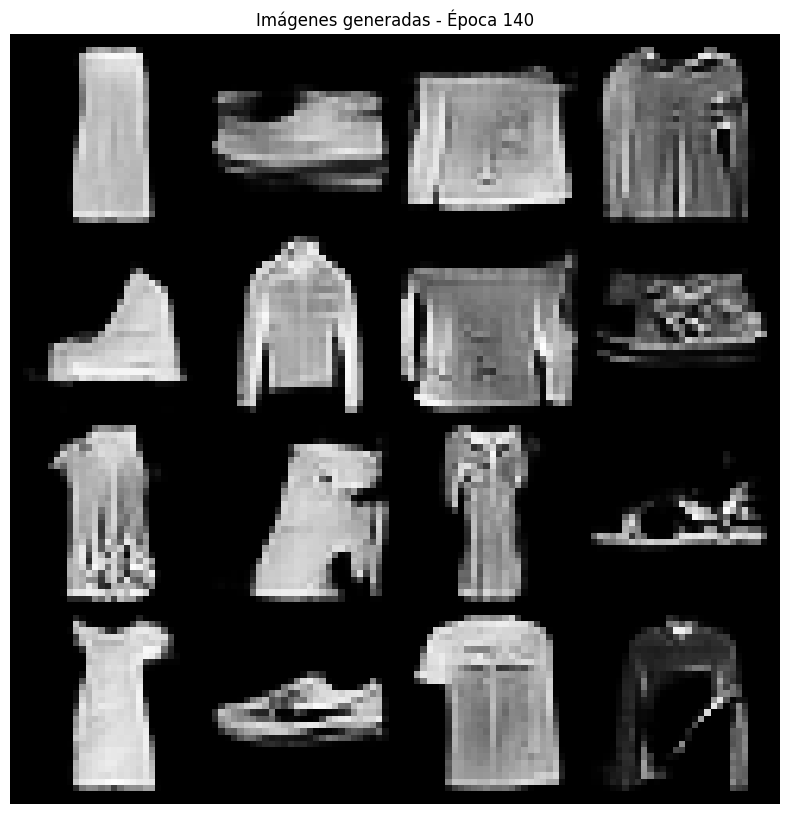

Epoch [141/200] D_loss: 0.6701, G_loss: 0.8480


Epoch [142/200] D_loss: 0.6722, G_loss: 0.8565


Epoch [143/200] D_loss: 0.6708, G_loss: 0.8572


Epoch [144/200] D_loss: 0.6701, G_loss: 0.8517


Epoch [145/200] D_loss: 0.6699, G_loss: 0.8558


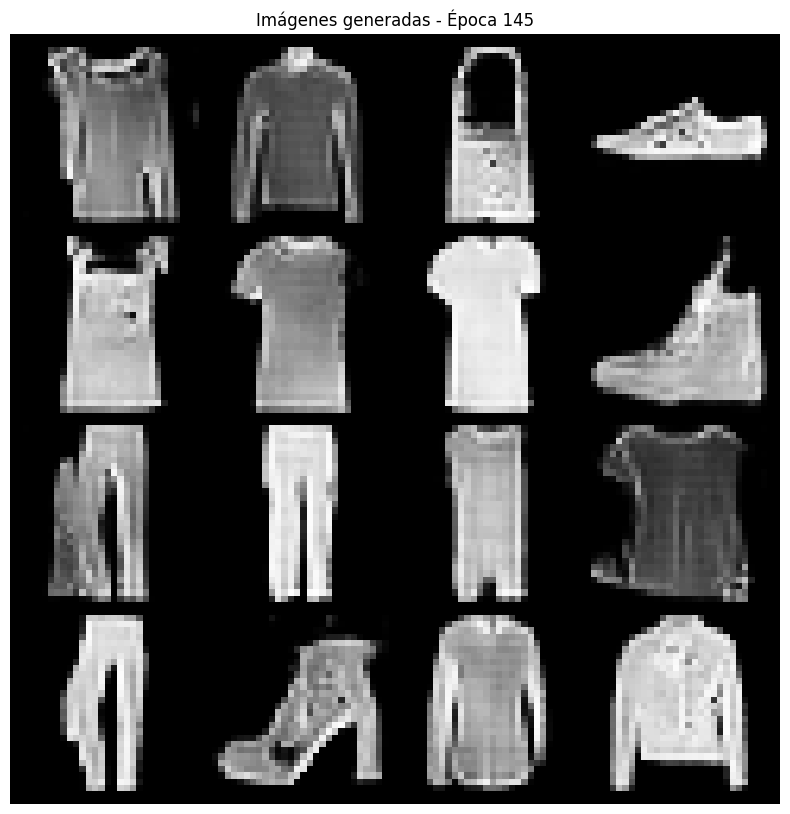

Epoch [146/200] D_loss: 0.6723, G_loss: 0.8517


Epoch [147/200] D_loss: 0.6719, G_loss: 0.8530


Epoch [148/200] D_loss: 0.6708, G_loss: 0.8535


Epoch [149/200] D_loss: 0.6725, G_loss: 0.8487


Epoch [150/200] D_loss: 0.6726, G_loss: 0.8543


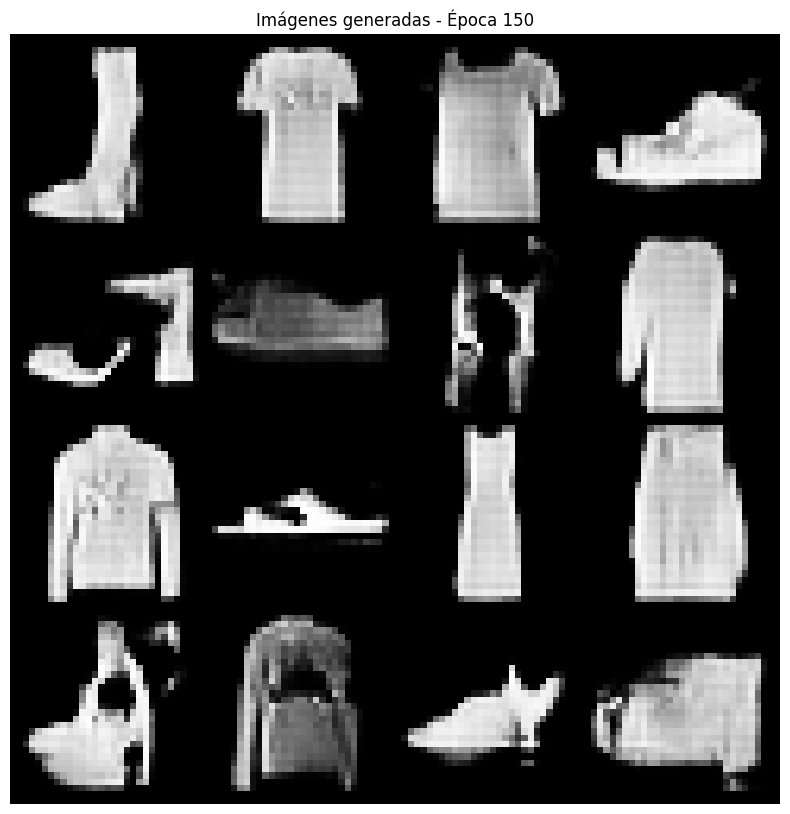

Epoch [151/200] D_loss: 0.6720, G_loss: 0.8530


Epoch [152/200] D_loss: 0.6718, G_loss: 0.8474


Epoch [153/200] D_loss: 0.6711, G_loss: 0.8455


Epoch [154/200] D_loss: 0.6705, G_loss: 0.8490


Epoch [155/200] D_loss: 0.6721, G_loss: 0.8493


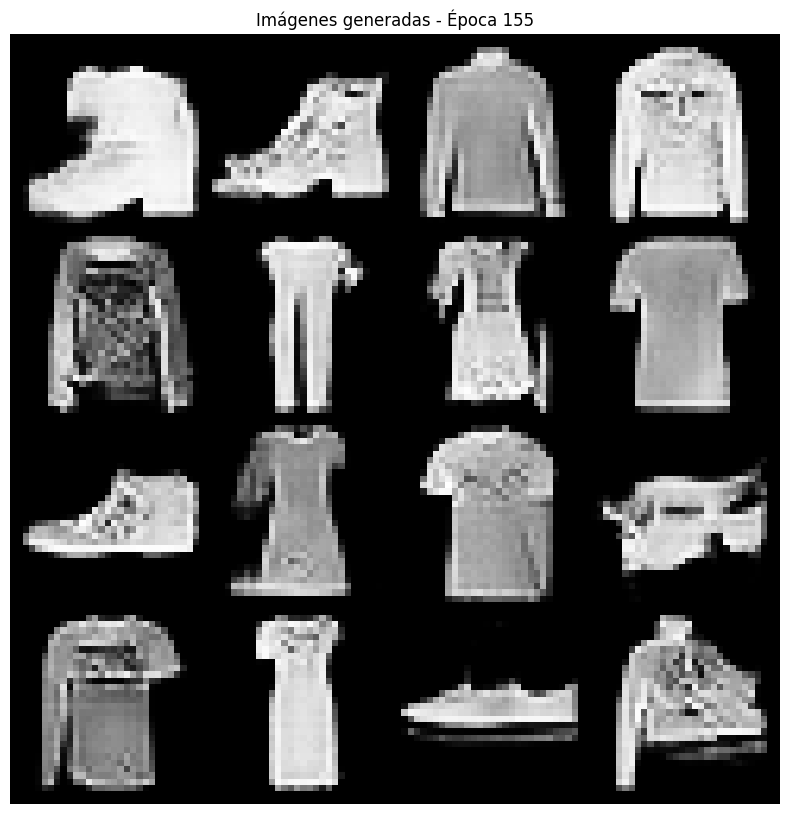

Epoch [156/200] D_loss: 0.6731, G_loss: 0.8478


Epoch [157/200] D_loss: 0.6719, G_loss: 0.8476


Epoch [158/200] D_loss: 0.6732, G_loss: 0.8487


Epoch [159/200] D_loss: 0.6716, G_loss: 0.8603


Epoch [160/200] D_loss: 0.6739, G_loss: 0.8438


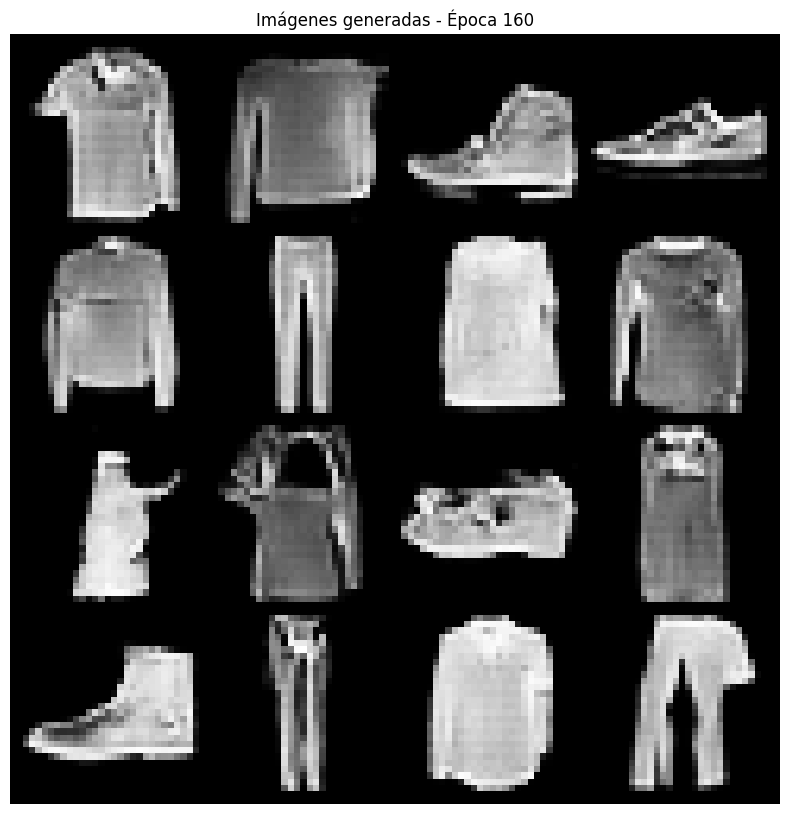

Epoch [161/200] D_loss: 0.6716, G_loss: 0.8457


Epoch [162/200] D_loss: 0.6730, G_loss: 0.8482


Epoch [163/200] D_loss: 0.6739, G_loss: 0.8439


Epoch [164/200] D_loss: 0.6734, G_loss: 0.8506


Epoch [165/200] D_loss: 0.6718, G_loss: 0.8459


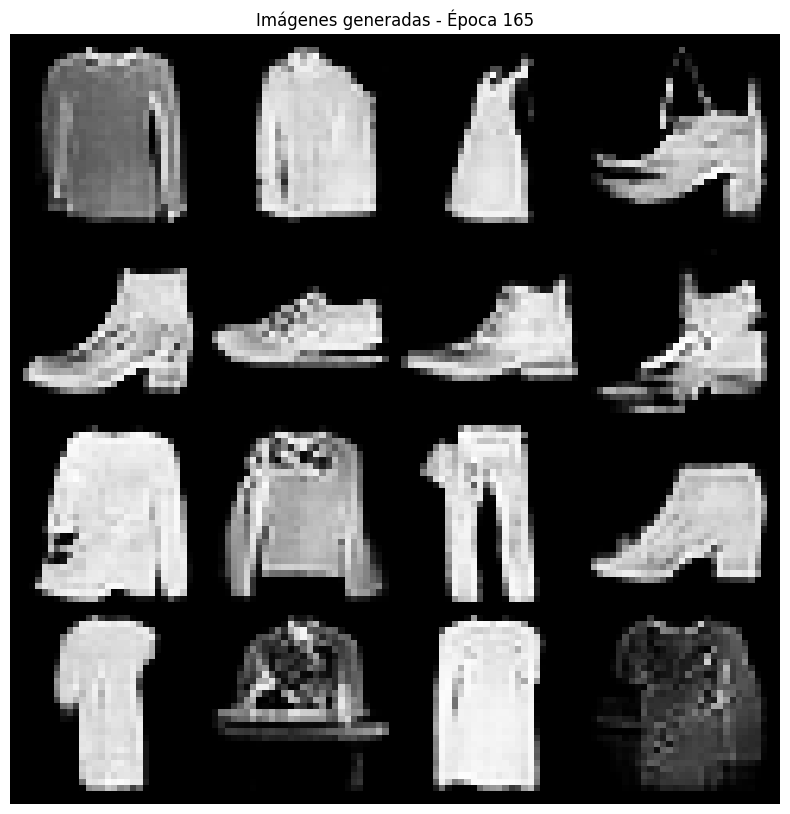

Epoch [166/200] D_loss: 0.6745, G_loss: 0.8426


Epoch [167/200] D_loss: 0.6721, G_loss: 0.8508


Epoch [168/200] D_loss: 0.6740, G_loss: 0.8472


Epoch [169/200] D_loss: 0.6749, G_loss: 0.8391


Epoch [170/200] D_loss: 0.6723, G_loss: 0.8486


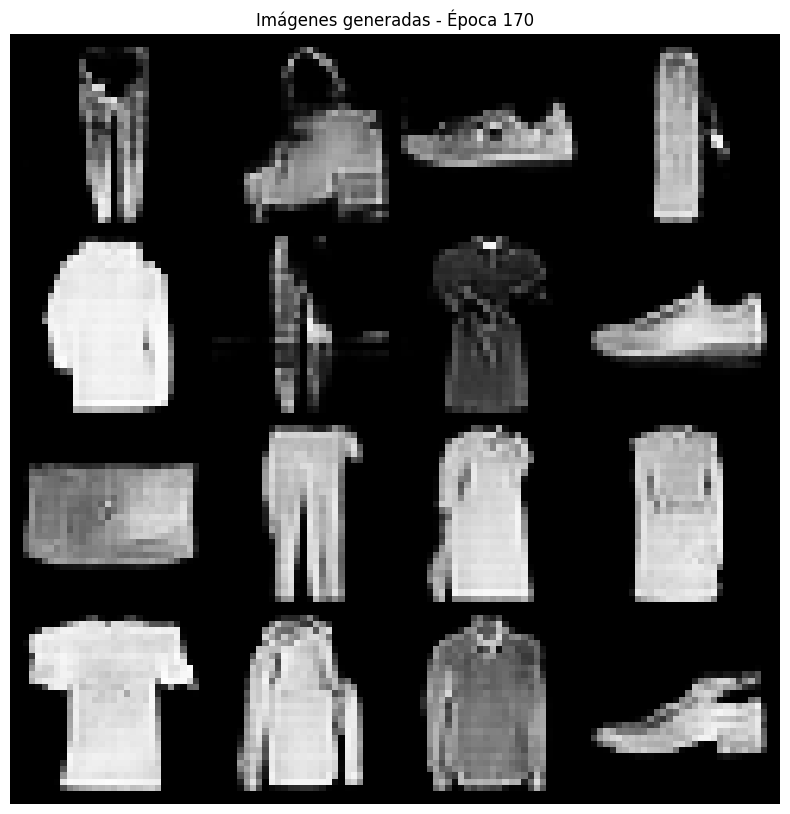

Epoch [171/200] D_loss: 0.6737, G_loss: 0.8425


Epoch [172/200] D_loss: 0.6736, G_loss: 0.8450


Epoch [173/200] D_loss: 0.6738, G_loss: 0.8433


Epoch [174/200] D_loss: 0.6734, G_loss: 0.8479


Epoch [175/200] D_loss: 0.6732, G_loss: 0.8434


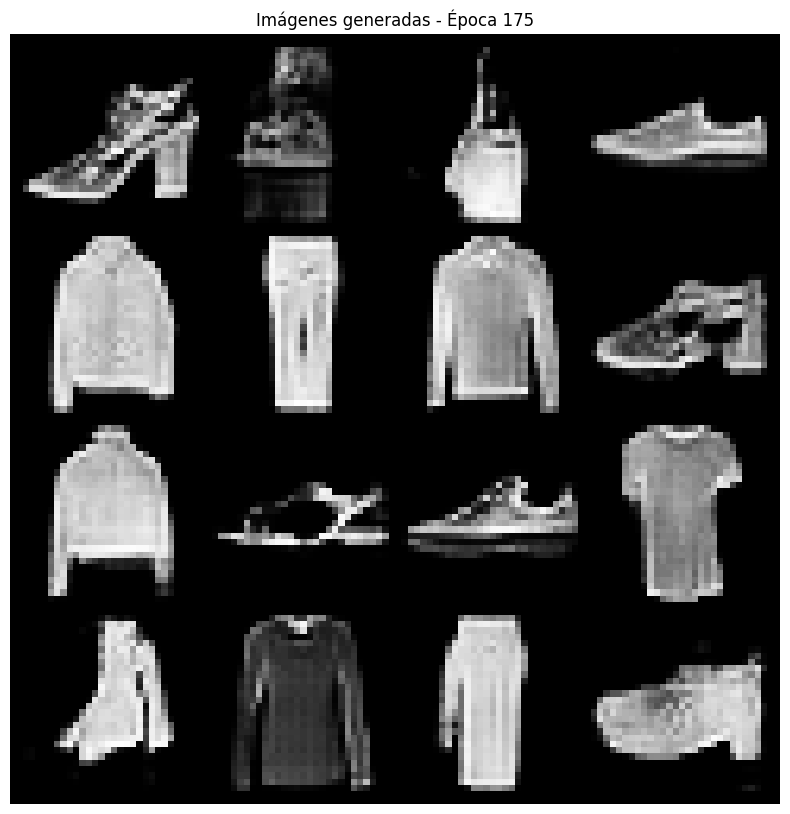

Epoch [176/200] D_loss: 0.6739, G_loss: 0.8454


Epoch [177/200] D_loss: 0.6744, G_loss: 0.8432


Epoch [178/200] D_loss: 0.6742, G_loss: 0.8473


Epoch [179/200] D_loss: 0.6736, G_loss: 0.8420


Epoch [180/200] D_loss: 0.6733, G_loss: 0.8422


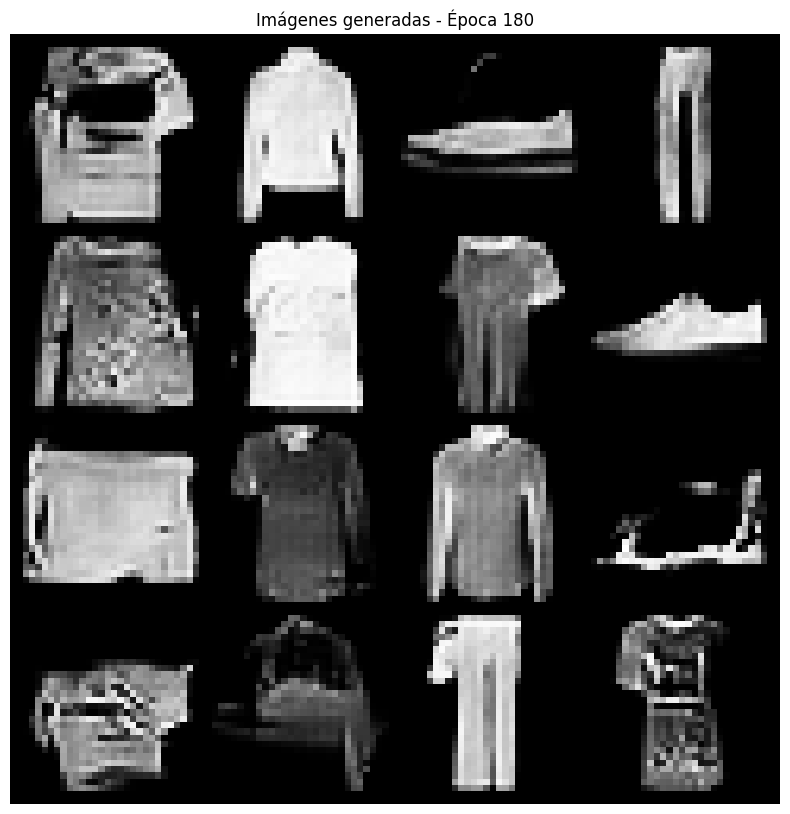

Epoch [181/200] D_loss: 0.6738, G_loss: 0.8435


Epoch [182/200] D_loss: 0.6740, G_loss: 0.8434


Epoch [183/200] D_loss: 0.6732, G_loss: 0.8443


Epoch [184/200] D_loss: 0.6735, G_loss: 0.8401


Epoch [185/200] D_loss: 0.6741, G_loss: 0.8516


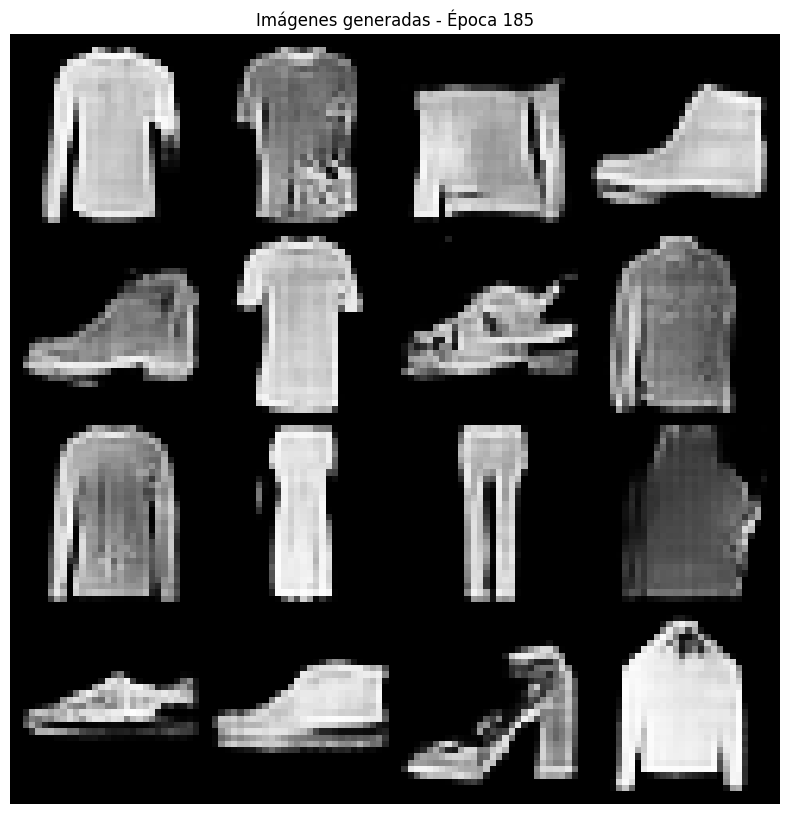

Epoch [186/200] D_loss: 0.6744, G_loss: 0.8407


Epoch [187/200] D_loss: 0.6736, G_loss: 0.8426


Epoch [188/200] D_loss: 0.6732, G_loss: 0.8420


Epoch [189/200] D_loss: 0.6756, G_loss: 0.8409


Epoch [190/200] D_loss: 0.6735, G_loss: 0.8455


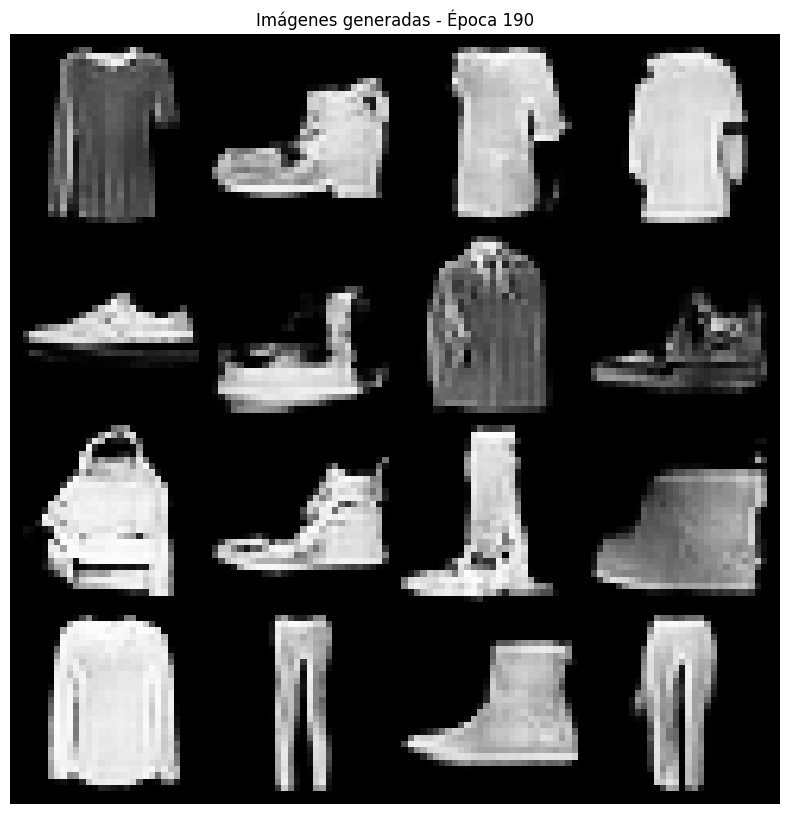

Epoch [191/200] D_loss: 0.6739, G_loss: 0.8422


Epoch [192/200] D_loss: 0.6747, G_loss: 0.8433


Epoch [193/200] D_loss: 0.6740, G_loss: 0.8448


Epoch [194/200] D_loss: 0.6735, G_loss: 0.8441


Epoch [195/200] D_loss: 0.6750, G_loss: 0.8410


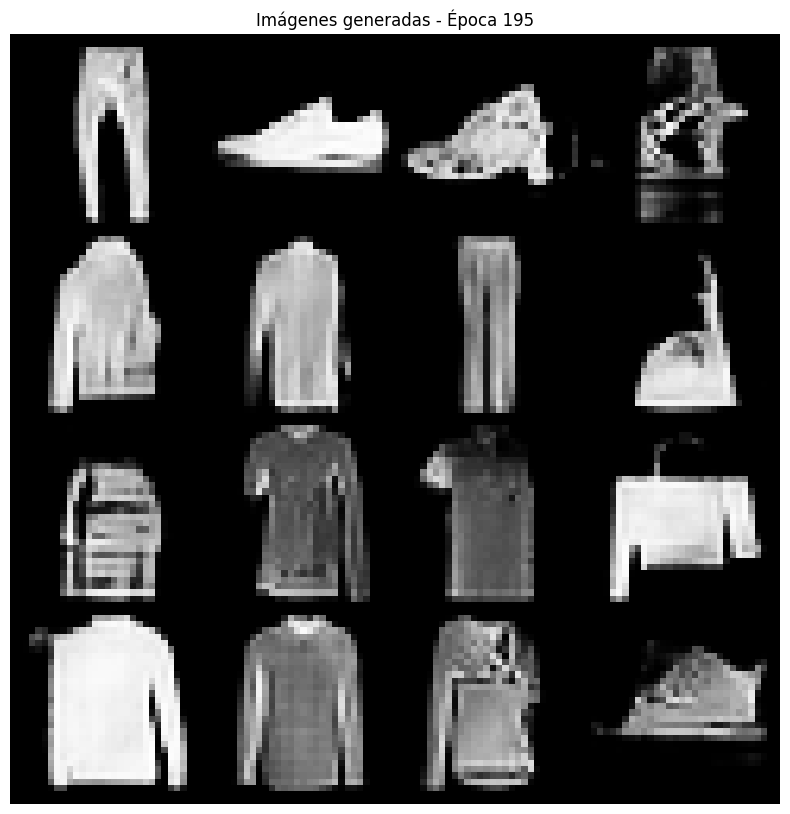

Epoch [196/200] D_loss: 0.6742, G_loss: 0.8402


Epoch [197/200] D_loss: 0.6752, G_loss: 0.8388


Epoch [198/200] D_loss: 0.6771, G_loss: 0.8391


Epoch [199/200] D_loss: 0.6729, G_loss: 0.8463


Epoch [200/200] D_loss: 0.6753, G_loss: 0.8353


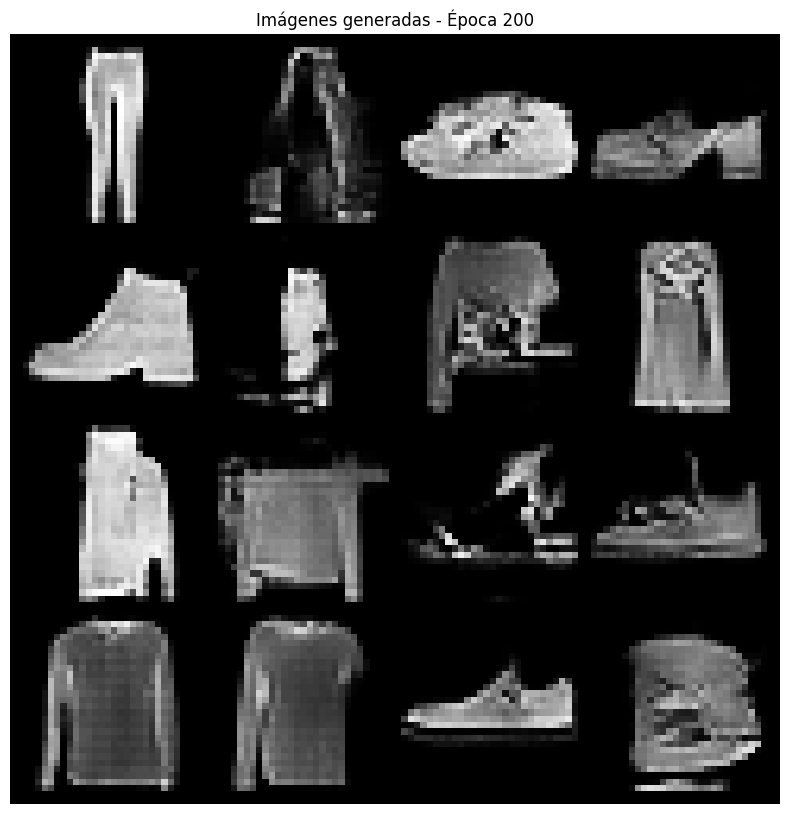

In [16]:
from tqdm import tqdm  # Librería tqdm para mostrar barras de progreso

# Ponemos ambos modelos en modo entrenamiento
generator.train()
discriminator.train()

# Entrenamiento de la GAN
# Entrenamiento de la GAN
for epoch in range(EPOCHS):
    epoch_disc_loss = 0
    epoch_gen_loss = 0

    for real_images, _ in tqdm(trainloader, desc=f"Epoch {epoch + 1}", leave=False):
        # Mover las imágenes a GPU si está disponible
        real_images = real_images.to(device)
        current_batch_size = real_images.size(0)

        # Crear etiquetas con ruido para mejorar la estabilidad
        real_labels = torch.ones(current_batch_size, 1, device=device) * 0.9  # Label smoothing
        fake_labels = torch.zeros(current_batch_size, 1, device=device)

        # -------- Entrenamiento del discriminador --------
        disc_optimizer.zero_grad()  # Mover aquí para mejor claridad

        # Generar imágenes falsas
        noise = torch.randn(current_batch_size, LATENT_DIM, device=device)
        with torch.no_grad():  # No necesitamos gradientes aquí
            generated_images = generator(noise)

        # Pérdida del discriminador con imágenes reales
        real_output = discriminator(real_images)
        real_loss = criterion(real_output, real_labels)

        # Pérdida del discriminador con imágenes falsas
        fake_output = discriminator(generated_images)
        fake_loss = criterion(fake_output, fake_labels)

        # Pérdida total del discriminador
        disc_loss = (real_loss + fake_loss) / 2  # Promedio para mejor estabilidad
        disc_loss.backward()
        disc_optimizer.step()

        epoch_disc_loss += disc_loss.item()

        # -------- Entrenamiento del generador --------
        gen_optimizer.zero_grad()

        # Generar nuevas imágenes falsas
        noise = torch.randn(current_batch_size, LATENT_DIM, device=device)
        generated_images = generator(noise)
        fake_output = discriminator(generated_images)
        
        # Calcular pérdida del generador
        gen_loss = criterion(fake_output, real_labels)
        gen_loss.backward()
        gen_optimizer.step()

        epoch_gen_loss += gen_loss.item()

    # Calcular pérdidas promedio
    avg_disc_loss = epoch_disc_loss / len(trainloader)
    avg_gen_loss = epoch_gen_loss / len(trainloader)

    print(f"Epoch [{epoch + 1}/{EPOCHS}] "
          f"D_loss: {avg_disc_loss:.4f}, G_loss: {avg_gen_loss:.4f}")
    
    # Mostrar algunas imágenes generadas cada N épocas
    if (epoch + 1) % 5 == 0:
        generator.eval()
        with torch.no_grad():
            sample_noise = torch.randn(16, LATENT_DIM, device=device)
            fake_images = generator(sample_noise)
            
            # Crear una figura con subplots
            plt.figure(figsize=(10, 10))
            plt.title(f"Imágenes generadas - Época {epoch+1}")
            
            # Crear grid de imágenes
            grid = vutils.make_grid(
                fake_images.cpu(),
                padding=2,
                normalize=True,
                nrow=4
            )
            
            # Mostrar el grid
            plt.imshow(grid.permute(1, 2, 0).numpy(), cmap='gray')
            plt.axis('off')
            plt.show()
            
            # Guardar algunas imágenes generadas cada N épocas
            save_images(fake_images, f"epoch_{epoch+1}")

        generator.train()
        


    # Cada 10 épocas guardamos el modelo
    if (epoch + 1) % 10 == 0:
        torch.save(generator.state_dict(), f'models/generator_{epoch + 1}.pth')
        torch.save(discriminator.state_dict(), f'models/discriminator_{epoch + 1}.pth')

# Guardamos el modelo
torch.save(generator.state_dict(), 'models/generator.pth')

In [21]:
# Genero un gif con las imagenes generadas
import imageio.v2 as imageio
import os

# Directorio con las imágenes generadas
images_dir = 'images'

# Lista de imágenes generadas
images = [img for img in os.listdir(images_dir) if img.endswith(".png")]

# Ordenamos las imágenes por el número de época
images.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))

# Creamos el gif
images_gif = []
for img in images:
    images_gif.append(imageio.imread(os.path.join(images_dir, img)))
    
# Guardamos el gif
imageio.mimsave('images/generated_images.gif', images_gif, fps=2, loop=0)

### Gif de la evolución de la GAN
<img src="./images/generated_images.gif" width="500" height="500" />
